<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_COVID19/blob/master/CovidModelsAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly

In [2]:

from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [4]:
cd MLTSA2020/

/content/gdrive/My Drive/MLTSA2020


In [5]:
cd COVID19/

/content/gdrive/My Drive/MLTSA2020/COVID19


In [6]:
ls

'Covid-19 Presentation.gslides'   KoreaConfirmedProphet.jpeg
'Covid-19 Proposal.gdoc'          KoreaConfirmedProphet.png
 data/                            NewDeathsKorea.jpeg
 data_sets/                       NewDeathsKorea.png
 DeathLagsKvsS.jpeg               NewDeathsKorea.svg
 DeathLagsKvsS.png


In [0]:
us = pd.read_csv('data_sets/usa_1/us_covid19_daily.csv')
#states = pd.read_csv('data_sets/usa_1/us_states_covid19_daily.csv')
states = pd.read_csv('data_sets/usa_1/us_state_c19_new.csv')
korea = pd.read_csv('data_sets/skcv19_data/sk_c19_new.csv')
#skcv19_data/sk_c19_new.csv’

In [8]:
ls

'Covid-19 Presentation.gslides'   KoreaConfirmedProphet.jpeg
'Covid-19 Proposal.gdoc'          KoreaConfirmedProphet.png
 data/                            NewDeathsKorea.jpeg
 data_sets/                       NewDeathsKorea.png
 DeathLagsKvsS.jpeg               NewDeathsKorea.svg
 DeathLagsKvsS.png


In [0]:
#TIME1 = all us, time2 = states, time = korea
time1 = us.copy()
time1.tail()
time1['date'] = pd.to_datetime(time1['date'], format='%Y%m%d')
time1 = time1.sort_values(by='date')
ind = np.where(time1.death >=5)[0][0]
time1 = time1[ind:]

confirmed_data_us=time1.reset_index().rename(columns={'date':'ds','positive':'y'})
deaths_us = time1.reset_index().rename(columns={'date':'ds','death':'y'})
tests_us = time1.reset_index().rename(columns={'date':'ds','test':'y'})
recovered_us = time1.reset_index().rename(columns={'date':'ds','released':'y'})

time2 = states.copy()
time2.tail()
time2['date'] = pd.to_datetime(time2['date'], format='%Y-%m-%d')
time2 = time2.sort_values(by='date')
ind = np.where(time2.death >=5)[0][0]
time2 = time2[ind:]

confirmed_data_st=time2.reset_index().rename(columns={'date':'ds','positive':'y'})
deaths_st = time2.reset_index().rename(columns={'date':'ds','death':'y'})
tests_st = time2.reset_index().rename(columns={'date':'ds','test':'y'})
recovered_st = time2.reset_index().rename(columns={'date':'ds','released':'y'})

time = korea.copy()
time.tail()
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')
time = time.sort_values(by='date')
ind = np.where(time.deceased >=5)[0][0]
time = time[ind:]

confirmed_data=time.reset_index().rename(columns={'date':'ds','confirmed':'y'})
deaths = time.reset_index().rename(columns={'date':'ds','deceased':'y'})
tests = time.reset_index().rename(columns={'date':'ds','test':'y'})
recovered = time.reset_index().rename(columns={'date':'ds','released':'y'})

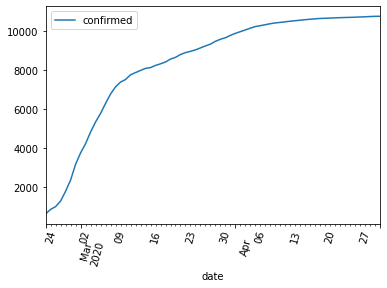

In [10]:
pd.plotting.register_matplotlib_converters()
time.plot(x='date',y='confirmed',rot = 75);

In [11]:
confirmed_data.shape

(68, 12)

### Daily increase

In [0]:
def daily(data):
    dailyIncrease = [0]
    for i in range(data.y.size-1):
        dailyIncrease.append(data.y[i+1]- data.y[i])
    return np.array(dailyIncrease)

In [0]:
confirmed_data['dailyIncrease'] = daily(confirmed_data)
deaths['dailyIncrease'] = daily(deaths)
tests['dailyIncrease'] = daily(tests)
recovered['dailyIncrease'] = daily(recovered)

Text(0.5, 1.0, 'Deaths daily increase')

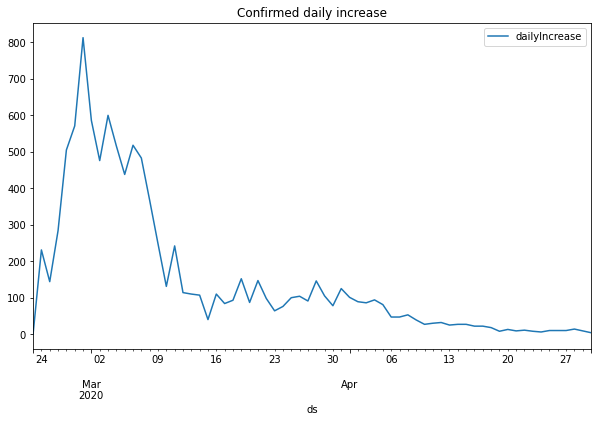

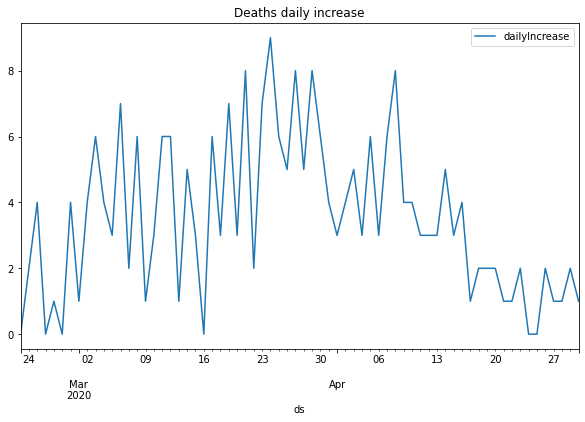

In [14]:
fig,ax=plt.subplots(figsize=(10,6))
confirmed_data.plot(x='ds',y='dailyIncrease',ax=ax)
ax.set_title('Confirmed daily increase')

fig,ax=plt.subplots(figsize=(10,6))
deaths.plot(x='ds',y='dailyIncrease',ax=ax)
ax.set_title('Deaths daily increase')


In [0]:
def mape(y, ytrue): #mean absolute percentage error
    return np.mean(np.abs((ytrue-y)/ytrue))

In [0]:
#future = simlog1.make_future_dataframe(periods=30)
#future['cap'] = 11000
#forecast = simlog1.predict(future)
#simlog2.plot_components(forecast);

### Logistics Growth - Define funcion with the coefficients to estimate the 'cap'.

In [0]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [0]:
from scipy.optimize import curve_fit

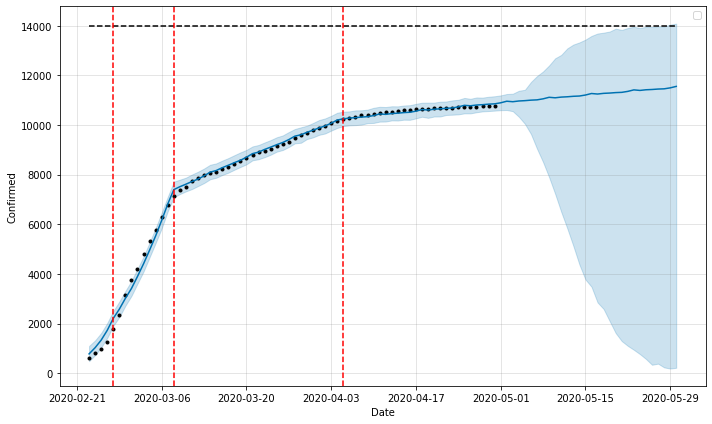

In [19]:
#define changepoints
simlog2 = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = confirmed_data
confirmed_train['cap'] = 14000
simlog2.fit(confirmed_train)
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = 14000
forecast = simlog2.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog2.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)
ax.legend()

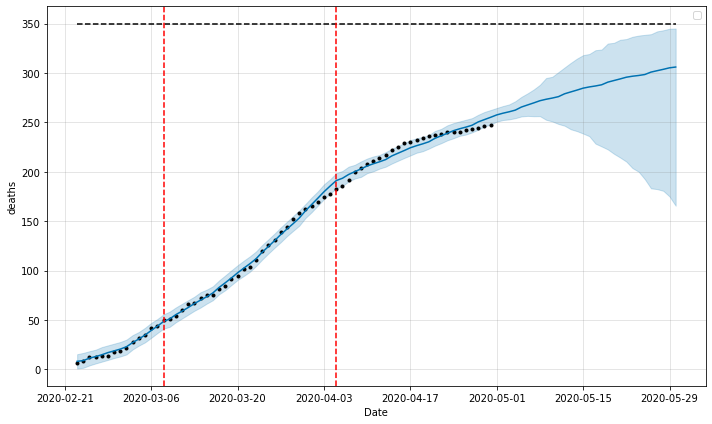

In [20]:
#define changepoints
cap = 350
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = deaths
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()

In [0]:
# for state, frame in deaths_st.groupby(['state']):
#   print(frame.y)


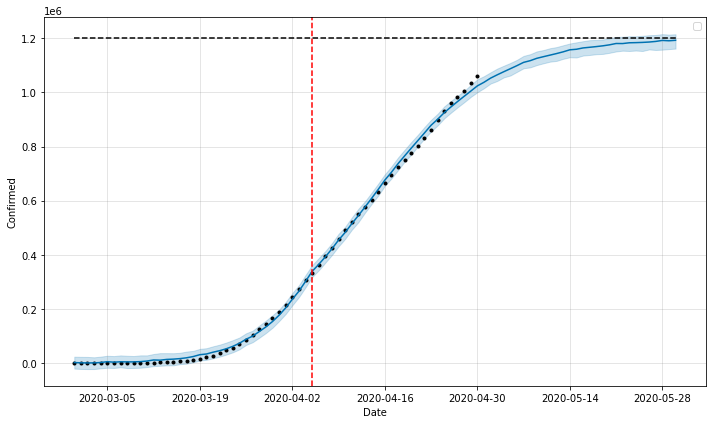

In [22]:
cap = 1200000
#define changepoints
simlog2 = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-29','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = confirmed_data_us
confirmed_train['cap'] = cap
simlog2.fit(confirmed_train)
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlog2.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog2.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)
ax.legend()

In [23]:
cvresult_simlog2 = cross_validation(simlog2, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))
performance_metrics(cvresult_simlog2)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-03-31 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.1133.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3.578752e+08,18917.589554,14334.540336,0.043875,0.010242,0.6
1,2 days,7.969828e+08,28230.883182,20121.396286,0.059277,0.011192,0.6
2,3 days,1.481982e+09,38496.514393,25704.757507,0.071246,0.008412,0.6
3,4 days,2.406181e+09,49052.837415,35080.026038,0.086283,0.013145,0.6
4,5 days,4.049753e+09,63637.666749,47419.217711,0.107386,0.027279,0.4
5,6 days,6.283901e+09,79271.060833,58962.239045,0.125542,0.033921,0.6
6,7 days,8.829182e+09,93963.728865,68369.851434,0.138555,0.034948,0.6
7,8 days,1.279520e+10,113115.868337,80580.258424,0.155627,0.038819,0.6
8,9 days,1.664174e+10,129002.864763,92515.409041,0.167545,0.046676,0.6
9,10 days,2.028023e+10,142408.672072,105746.197510,0.178105,0.054498,0.4


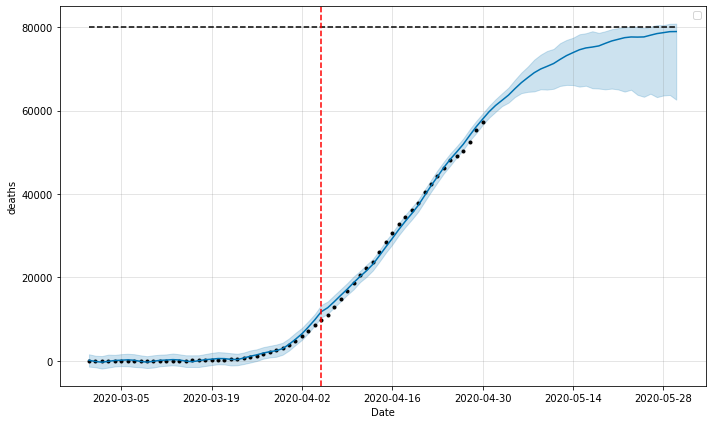

In [24]:
cap = 80000
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-29','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = deaths_us
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()

These 4 figures overlayed, after you take dshifted into account


In [25]:
cvresult_simlogd = cross_validation(simlogd, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlogd.yhat, 
                                                           cvresult_simlogd.y)))
performance_metrics(cvresult_simlogd)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-03-31 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.1772.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,8.686487e+05,932.013243,778.791884,0.042780,0.025632,0.0
1,2 days,1.989169e+06,1410.379188,1285.488867,0.063879,0.046181,0.0
2,3 days,4.534664e+06,2129.475162,2008.063087,0.095013,0.088902,0.0
3,4 days,8.085915e+06,2843.574272,2706.382731,0.121665,0.103406,0.0
4,5 days,1.319673e+07,3632.729920,3498.933463,0.154234,0.108967,0.2
5,6 days,2.179931e+07,4668.972849,4510.453824,0.193767,0.128146,0.2
6,7 days,3.565597e+07,5971.262320,5701.458555,0.228589,0.149581,0.4
7,8 days,5.547437e+07,7448.111946,7008.897895,0.267204,0.178427,0.4
8,9 days,7.566433e+07,8698.524790,8072.388756,0.292186,0.206298,0.4
9,10 days,1.000753e+08,10003.763840,9198.604242,0.312935,0.230510,0.4


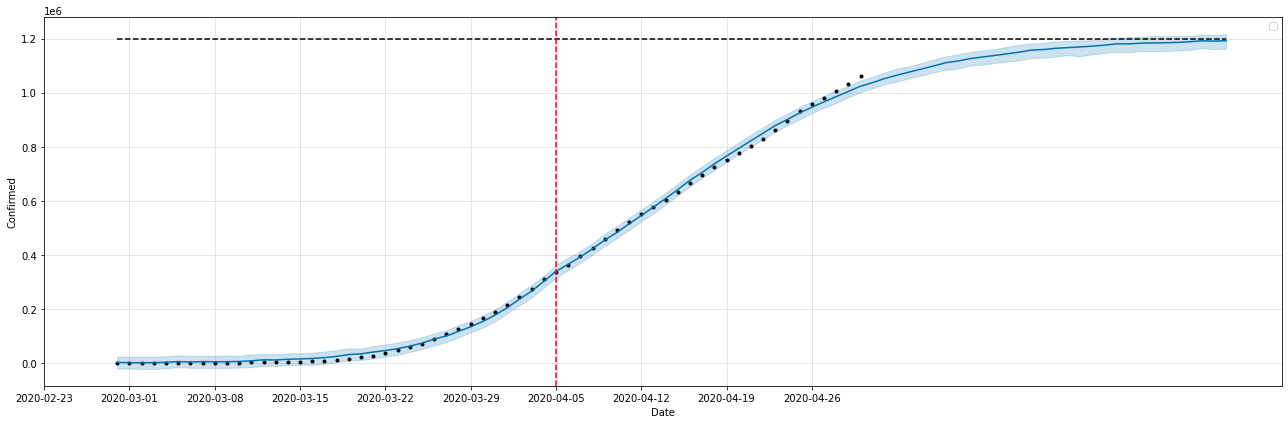

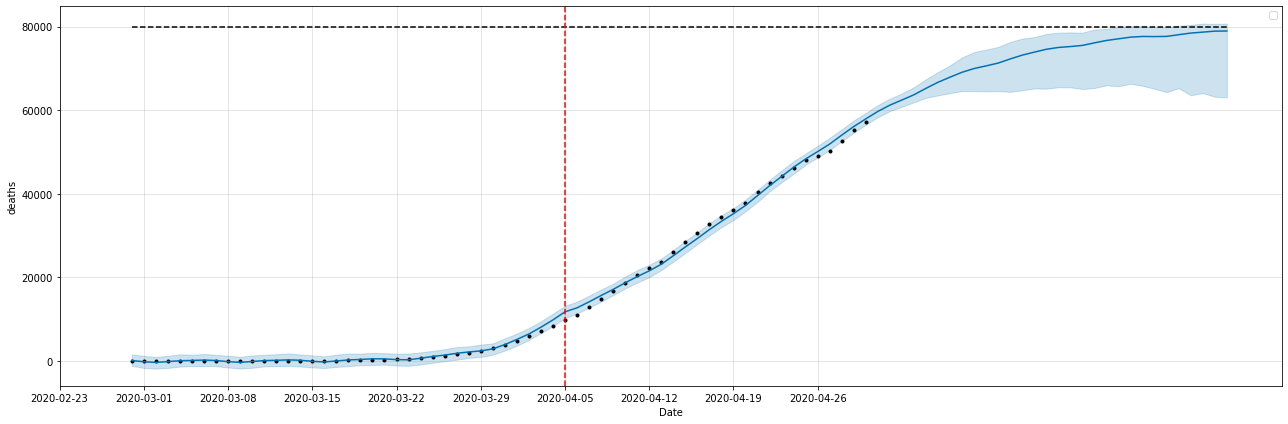

In [26]:
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = 1200000
forecast = simlog2.predict(future)

fig5, ax = plt.subplots(figsize=(18,6))
simlog2.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
ticks = deaths['ds'][::7]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)
ax.legend()

future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)

fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ticks = deaths['ds'][::7]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()

In [27]:
cvresult_simlog2 = cross_validation(simlog2, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))
performance_metrics(cvresult_simlog2)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-03-31 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.1133.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3.578752e+08,18917.589554,14334.540336,0.043875,0.010242,0.6
1,2 days,7.969828e+08,28230.883182,20121.396286,0.059277,0.011192,0.6
2,3 days,1.481982e+09,38496.514393,25704.757507,0.071246,0.008412,0.6
3,4 days,2.406181e+09,49052.837415,35080.026038,0.086283,0.013145,0.6
4,5 days,4.049753e+09,63637.666749,47419.217711,0.107386,0.027279,0.4
5,6 days,6.283901e+09,79271.060833,58962.239045,0.125542,0.033921,0.4
6,7 days,8.829182e+09,93963.728865,68369.851434,0.138555,0.034948,0.6
7,8 days,1.279520e+10,113115.868337,80580.258424,0.155627,0.038819,0.6
8,9 days,1.664174e+10,129002.864763,92515.409041,0.167545,0.046676,0.6
9,10 days,2.028023e+10,142408.672072,105746.197510,0.178105,0.054498,0.4


In [0]:
CA = deaths_st[deaths_st['state'] == 'CA']
NY = deaths_st[deaths_st['state'] == 'NY']
FL = deaths_st[deaths_st['state'] == 'FL']
DC = deaths_st[deaths_st['state'] == 'DC']
NE = deaths_st[deaths_st['state'] == 'NE']

CA = CA[CA.y >= 5].reset_index(drop = True)
NY = NY[NY.y >= 5].reset_index(drop = True)
NE = NE[NE.y >= 5].reset_index(drop = True)
DC = DC[DC.y >= 5].reset_index(drop = True)
FL = FL[FL.y >= 5].reset_index(drop = True)

In [0]:
NE = NE.reset_index(drop = True)
DC = DC.reset_index(drop = True)
FL = FL.reset_index(drop = True)
NY = NY.reset_index(drop = True)

In [0]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 14}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 26})
# matplotlib.rcParams['lines.linewidth'] = 4

# dshifted = deaths.shift(-22)
# fig, axs = plt.subplots(6, 2, figsize = (52,28))
# axs[0,0].plot(dshifted['dailyIncrease']*70, 'b', label = 'Deaths. Shift: 22 days. Factor: 70')
# axs[0,0].plot(confirmed_data['dailyIncrease'], 'r', label = 'Confirmed Cases')
# axs[0,0].legend()
# axs[0,0].set_title('Korea: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[0,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[0,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[0,1].plot(dshifted['y']*42, 'b', label = 'Deaths. Shift: 22 days. Factor: 42')
# axs[0,1].plot(confirmed_data['y'], 'r', label = 'Confirmed Cases')
# axs[0,1].legend()
# axs[0,1].set_title('Korea: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[0,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[0,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# dshifted = CA.shift(-6)
# axs[1,0].plot(dshifted['deathIncrease']*18, 'b', label = 'Deaths. Shift: 6 days. Factor: 18')
# axs[1,0].plot(CA['positiveIncrease'], 'r', label = 'Confirmed Cases')
# axs[1,0].legend()
# axs[1,0].set_title('California: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[1,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[1,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[1,1].plot(dshifted['y']*20, 'b', label = 'Deaths. Shift: 6 days. Factor: 20')
# axs[1,1].plot(CA['positive'], 'r', label = 'Confirmed Cases')
# axs[1,1].legend()
# axs[1,1].set_title('California: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[1,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[1,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# dshifted = NY.shift(-6)
# axs[2,0].plot(dshifted['deathIncrease']*14, 'b', label = 'Deaths. Shift: 6 days. Factor: 14')
# axs[2,0].plot(NY['positiveIncrease'], 'r', label = 'Confirmed Cases')
# axs[2,0].legend()
# axs[2,0].set_title('New York: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[2,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[2,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[2,1].plot(dshifted['y']*14, 'b', label = 'Deaths. Shift: 6 days. Factor: 14')
# axs[2,1].plot(NY['positive'], 'r', label = 'Confirmed Cases')
# axs[2,1].legend()
# axs[2,1].set_title('New York: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[2,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[2,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# dshifted = NE.shift(-2)
# axs[3,0].plot(dshifted['deathIncrease']*20, 'b', label = 'Deaths. Shift: 2 days. Factor: 20')
# axs[3,0].plot(NE['positiveIncrease'], 'r', label = 'Confirmed Cases')
# axs[3,0].legend()
# axs[3,0].set_title('Nebraska: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[3,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[3,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[3,1].plot(dshifted['y']*35, 'b', label = 'Deaths. Shift: 2 days. Factor: 35')
# axs[3,1].plot(NE['positive'], 'r', label = 'Confirmed Cases')
# axs[3,1].legend()
# axs[3,1].set_title('Nebraska: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[3,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[3,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# dshifted = DC.shift(-6)
# axs[4,0].plot(dshifted['deathIncrease']*14, 'b', label = 'Deaths. Shift: 6 days. Factor: 14')
# axs[4,0].plot(DC['positiveIncrease'], 'r', label = 'Confirmed Cases')
# axs[4,0].legend()
# axs[4,0].set_title('D.C.: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[4,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[4,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[4,1].plot(dshifted['y']*19, 'b', label = 'Deaths. Shift: 6 days. Factor: 19')
# #axs[4,1].plot(DC['positive'], 'r', label = 'Confirmed Cases')
# axs[4,1].plot(DC['positive'], 'r', label = 'Confirmed Cases')
# axs[4,1].legend()
# axs[4,1].set_title('D.C.: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[4,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[4,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# dshifted = FL.shift(-12)
# axs[5,0].plot(dshifted['deathIncrease']*21, 'b', label = 'Deaths. Shift: 12 days. Factor: 21')
# axs[5,0].plot(FL['positiveIncrease'], 'r', label = 'Confirmed Cases')
# axs[5,0].legend()
# axs[5,0].set_title('Florida: Daily Deaths vs Confirmed Cases', fontsize = 40)
# axs[5,0].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[5,0].set_xlabel('Days since 5 deaths', fontsize = 34)

# axs[5,1].plot(dshifted['y']*17, 'b', label = 'Deaths. Shift: 12 days. Factor: 17')
# axs[5,1].plot(FL['positive'], 'r', label = 'Confirmed Cases')
# axs[5,1].legend()
# axs[5,1].set_title('Florida: Cumulative Deaths vs Confirmed Cases', fontsize = 40)
# axs[5,1].set_ylabel('Cases/Deaths', fontsize = 34)
# axs[5,1].set_xlabel('Days since 5 deaths', fontsize = 34)

# fig.tight_layout()
#plt.savefig('DeathLagsKvsS.jpeg', qualtiy = 95)
#plt.savefig('DeathLagsKvsS.png', format='png', dpi=900, bbox_inches = 'tight')

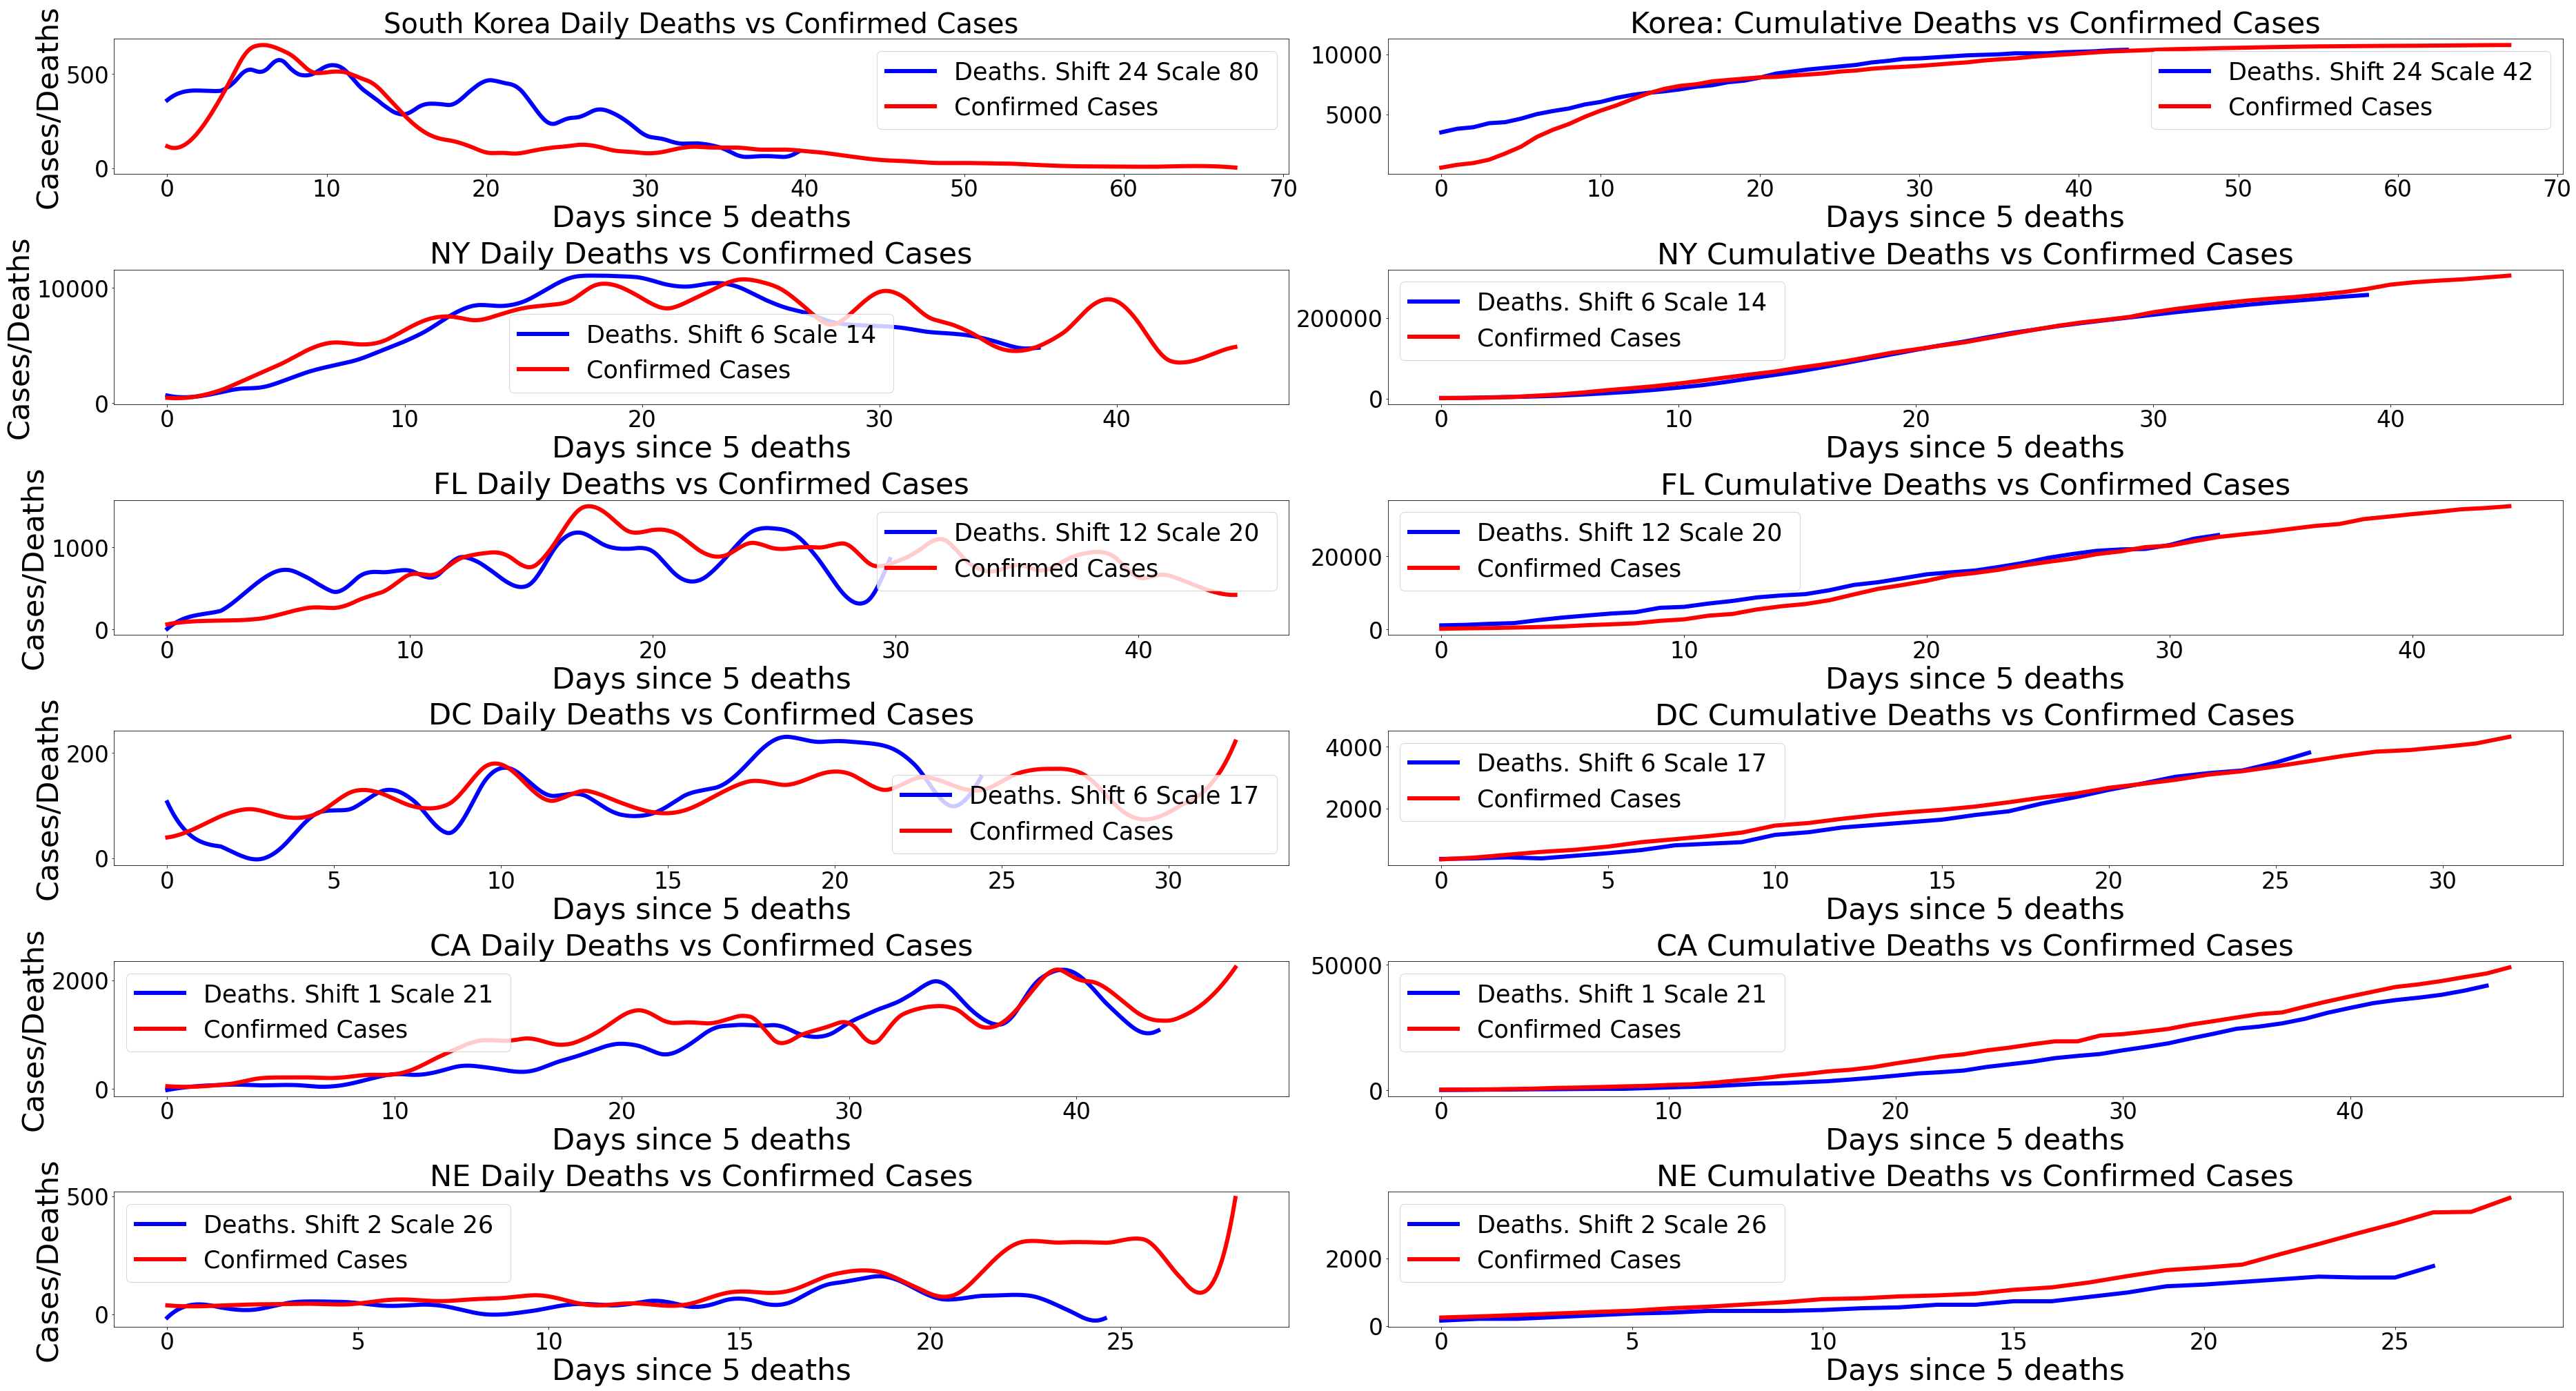

In [31]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import numpy as np
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 6
label_size = 43
legend_size = 35
tick_size = 33
#label_size = 32
#legend_size = 

state_hold = [NY, NY, FL, DC, CA, NE]
shift_i = [0, 6, 12, 6, 1, 2]
scale_i = [0, 14, 20, 17, 21, 26]
fig, axs = plt.subplots(6, 2, figsize = (52,28))

#KOREA
kshift = 24
kfactor = 80
dshifted = deaths.shift(-kshift)
datas = dshifted['dailyIncrease']
x = np.arange(len(datas))
y = datas
xx = np.linspace(x.min(),x.max(), 1000)
itp = interp1d(x,y, kind='linear')
window_size, poly_order = 101, 3
yy_sg = savgol_filter(itp(xx), window_size, poly_order)
axs[0,0].plot(xx, yy_sg*kfactor, 'b', label = 'Deaths. Shift %d Scale %d ' % (kshift, kfactor))

datas = confirmed_data['dailyIncrease']
x = np.arange(len(datas))
y = datas
xx = np.linspace(x.min(),x.max(), 1000)
itp = interp1d(x,y, kind='linear')
window_size, poly_order = 101, 3
yy_sg = savgol_filter(itp(xx), window_size, poly_order)
axs[0,0].plot(xx, yy_sg, 'r', label = 'Confirmed Cases')
axs[0,0].legend(fontsize = legend_size)
axs[0,0].set_title('%s Daily Deaths vs Confirmed Cases' % 'South Korea', fontsize = 40)
axs[0,0].set_ylabel('Cases/Deaths', fontsize = label_size)
axs[0,0].set_xlabel('Days since 5 deaths', fontsize = label_size)
axs[0,0].tick_params(axis = 'both', labelsize = tick_size)

axs[0,1].plot(dshifted['y']*42, 'b', label = 'Deaths. Shift %d Scale %d ' % (kshift, 42))
axs[0,1].plot(confirmed_data['y'], 'r', label = 'Confirmed Cases')
axs[0,1].legend()
axs[0,1].set_title('Korea: Cumulative Deaths vs Confirmed Cases', fontsize = label_size)
axs[0,1].set_xlabel('Days since 5 deaths', fontsize = label_size)
axs[0,1].legend(fontsize = legend_size)
axs[0,1].set_xlabel('Days since 5 deaths', fontsize = label_size)
axs[0,1].tick_params(axis = 'both', labelsize = tick_size)

for i in range(1,len(state_hold)):
#for i in range(1,2):
  state_i = state_hold[i]
  dshifted = state_i.shift(-shift_i[i])

  datas = dshifted['deathIncrease']
  x = np.arange(len(datas))
  y = datas
  xx = np.linspace(x.min(),x.max(), 1000)
  itp = interp1d(x,y, kind='linear')
  window_size, poly_order = 101, 3
  yy_sg = savgol_filter(itp(xx), window_size, poly_order)
  axs[i,0].plot(xx, yy_sg*scale_i[i], 'b', label = 'Deaths. Shift %d Scale %d ' % (shift_i[i], scale_i[i]))

  datas = state_i['positiveIncrease']
  x = np.arange(len(datas))
  y = datas
  xx = np.linspace(x.min(),x.max(), 1000)
  itp = interp1d(x,y, kind='linear')
  window_size, poly_order = 101, 3
  yy_sg = savgol_filter(itp(xx), window_size, poly_order)
  axs[i,0].plot(xx, yy_sg, 'r', label = 'Confirmed Cases') 

  axs[i,0].legend(fontsize = legend_size)
  axs[i,0].set_title('%s Daily Deaths vs Confirmed Cases' % state_i['state'][0], fontsize = label_size)
  axs[i,0].set_ylabel('Cases/Deaths', fontsize = label_size)
  axs[i,0].set_xlabel('Days since 5 deaths', fontsize = label_size)
  axs[i,0].tick_params(axis = 'both', labelsize = tick_size)

  axs[i,1].plot(dshifted['y']*scale_i[i], 'b', label = 'Deaths. Shift %d Scale %d ' % (shift_i[i], scale_i[i]))
  axs[i,1].plot(state_i['positive'], 'r', label = 'Confirmed Cases')
  axs[i,1].legend(fontsize = legend_size)
  axs[i,1].set_title('%s Cumulative Deaths vs Confirmed Cases' % state_i['state'][0], fontsize = label_size)
  axs[i,1].set_xlabel('Days since 5 deaths', fontsize = label_size)
  axs[i,1].tick_params(axis = 'both', labelsize = tick_size)
fig.tight_layout()
plt.savefig('DeathLagsKvsS.png', format='png', dpi = 300, bbox_inches = 'tight')

graph of death shift for South Korea and states, with shift and factor put in

To get daily death increase and daily confirmed increase to match up for Korea, you need to shift over 18 days (after 5 deaths) and increase death by 16.

Shift over 20 for death (I.E. the first 20 days are gone) and multiply by 42 (1 death = 42 confirmed cases), and start collecting after 5 deaths. Line up pretty well.
Population of Korea is 51.64 million

In [0]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [34]:
time.index[0]

34

a =  0.16125384543973553
b =  1.1334991772440646
c =  8369.56874655437


Text(0.5, 0, 'index')

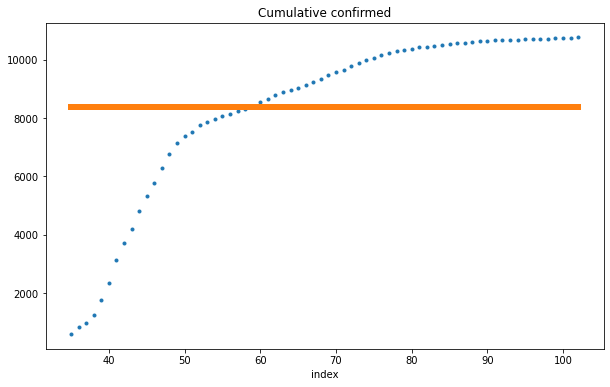

In [35]:
p0 = np.random.exponential(size=3)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['confirmed'])
(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)
print('a = ',a)
print('b = ',b)
print('c = ',c)
fig,ax=plt.subplots(figsize=(10,6))
xx=x
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative confirmed')
ax.set_xlabel('index')



a =  441.7826802915299
b =  0.09172886206184092
c =  256.60174996665006


Text(0.5, 0, 'index')

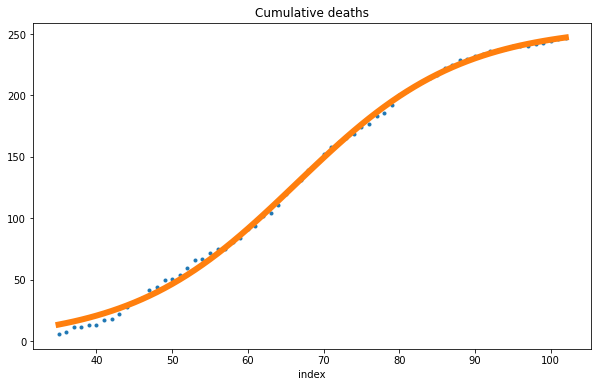

In [36]:
p0 = np.random.exponential(size=3)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['deceased'])
(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)
print('a = ',a)
print('b = ',b)
print('c = ',c)
fig,ax=plt.subplots(figsize=(10,6))
xx=x
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')

In [0]:
import scipy

a =  1060.473117518585
b =  -20.623199559558117
c =  0.09732086335205978
(array([0]),)


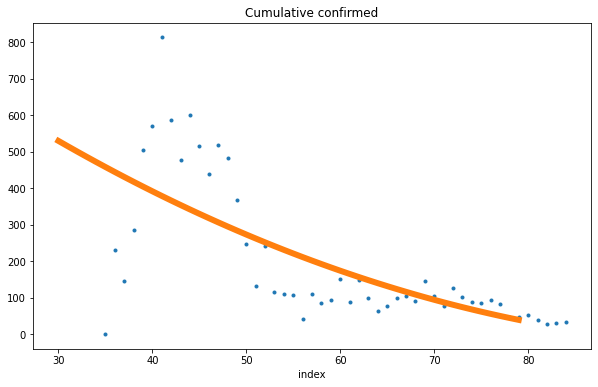

In [38]:
cut_off = 50
def GaussPolyBase(f, a, b, c, P, fp, fw):
    return a + b*f + c*f*f + P*np.exp(-0.5*((f-fp)/fw)**2)
p0 = np.random.exponential(size=6)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values[:cut_off])+1
y = np.array(confirmed_data['dailyIncrease'][:cut_off])
# (a,b,c),cov = curve_fit(func_logistic, 
#                               x, y, bounds=bounds, p0=p0, maxfev=1000000)

f = x
s = y
#a0, b0, c0 = 60., -3., 0.
#P0, fp0, fw0 = 80., 11., 2.
nlfit, nlpcov = scipy.optimize.curve_fit(GaussPolyBase,
                f, s, p0=p0)
a, b, c, P, fp, fw = nlfit
f_fit = np.arange(30,80)
s_fit = GaussPolyBase(f_fit, a, b, c, P, fp, fw)

print('a = ',a)
print('b = ',b)
print('c = ',c)
fig,ax=plt.subplots(figsize=(10,6))
xx=f_fit
ax.plot(x, y,'.')
ax.plot(f_fit, s_fit)
ax.set_title('Cumulative confirmed')
ax.set_xlabel('index')
print(np.where(s_fit == np.max(s_fit)))

a =  -50.64504809483742
b =  2.28509267215462
c =  -0.023828340197078704
(array([18]),)


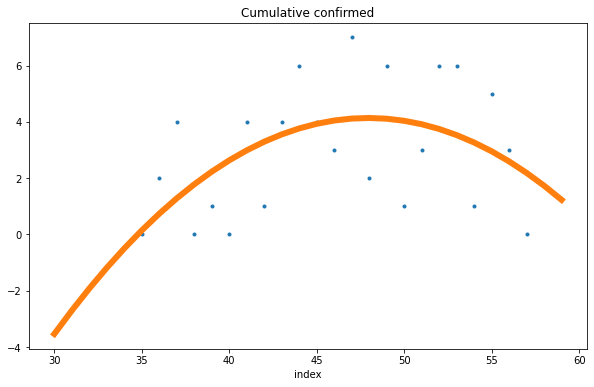

In [39]:
cut_off = 23
def GaussPolyBase(f, a, b, c, P, fp, fw):
    return a + b*f + c*f*f + P*np.exp(-0.5*((f-fp)/fw)**2)
p0 = np.random.exponential(size=6)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values[:cut_off])+1
y = np.array(deaths['dailyIncrease'][:cut_off])
# (a,b,c),cov = curve_fit(func_logistic, 
#                               x, y, bounds=bounds, p0=p0, maxfev=1000000)

f = x
s = y
#a0, b0, c0 = 60., -3., 0.
#P0, fp0, fw0 = 80., 11., 2.
nlfit, nlpcov = scipy.optimize.curve_fit(GaussPolyBase,
                f, s, p0=p0)
a, b, c, P, fp, fw = nlfit
f_fit = np.arange(30,60)
s_fit = GaussPolyBase(f_fit, a, b, c, P, fp, fw)

print('a = ',a)
print('b = ',b)
print('c = ',c)
fig,ax=plt.subplots(figsize=(10,6))
xx=f_fit
ax.plot(x, y,'.')
ax.plot(f_fit, s_fit)
ax.set_title('Cumulative confirmed')
ax.set_xlabel('index')
print(np.where(s_fit == np.max(s_fit)))

a =  0.5854200015750051
b =  3.5037000705443164
c =  135.23529411764704
a =  0.21473845436346836
b =  1.1826256278532497
c =  8369.517139607466


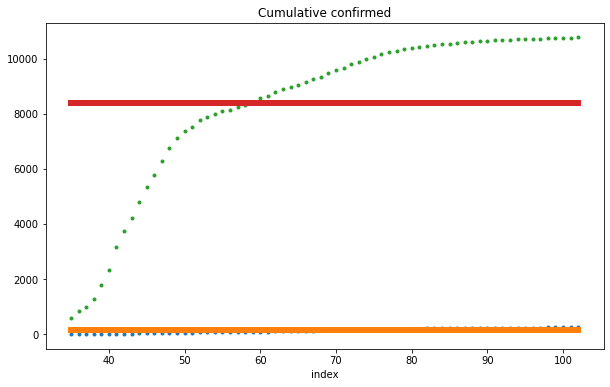

In [40]:
p0 = np.random.exponential(size=3)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['deceased'])
(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)
print('a = ',a)
print('b = ',b)
print('c = ',c)
fig,ax=plt.subplots(figsize=(10,6))
xx=x
ax.plot(x, y,'.')
ax.plot(xx, func_logistic(xx, a, b, c))
ax.set_title('Cumulative deaths')
ax.set_xlabel('index')

p02 = np.random.exponential(size=3)
# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])
# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x2 = np.array(time.index.values)+1
y2 = np.array(time['confirmed'])
(a,b,c),cov = curve_fit(func_logistic, 
                              x2, y2, bounds=bounds, p0=p02, maxfev=1000000)
print('a = ',a)
print('b = ',b)
print('c = ',c)
#fig,ax=plt.subplots(figsize=(10,6))
xx2=x
ax.plot(x2, y2,'.')
ax.plot(xx2, func_logistic(xx2, a, b, c))
ax.set_title('Cumulative confirmed')
ax.set_xlabel('index')
plt.show()

In [0]:
# def func(x, a, b, n):
#   return 10**(a * (x - n) + b * (x - n)**2 ) 

In [0]:
# xdata = np.linspace(0,102, 102)
# ydata = deathnoz.y
# popt, pcov = curve_fit(func, xdata, ydata)
# popt
# plt.plot(xdata, func(xdata, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [0]:

# def func_powerlaw(x, m, c, c0):
#     return c0 + x**m * c

# target_func = func_powerlaw
# plt.figure(figsize=(10, 5))
# plt.plot(xdata[30:], target_func(xdata[30:], *popt), '--')
# plt.plot(xdata, ydata, 'ro')
# plt.legend()
# plt.show()

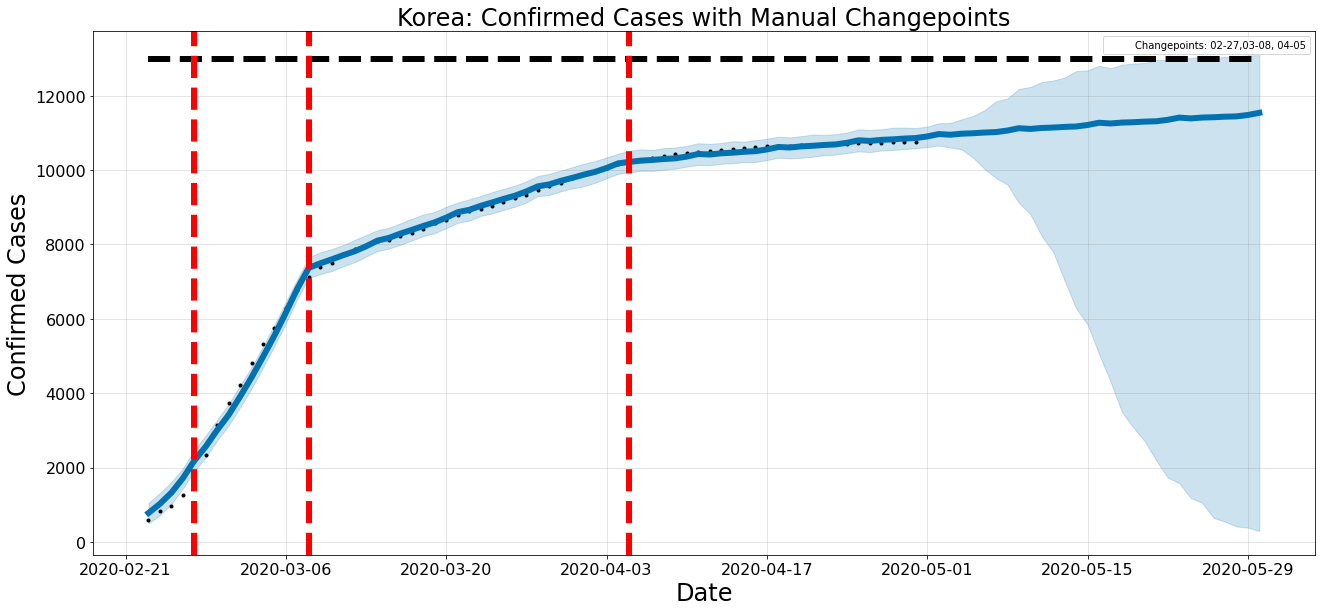

In [45]:
import matplotlib
ont = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

#matplotlib.rc('font', **font)
#matplotlib.rcParams.update({'font.size': 11})

cap = 13000
simlogc = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = confirmed_data
confirmed_train['cap'] = cap
simlogc.fit(confirmed_train)
future = simlogc.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogc.predict(future)

fig5, ax = plt.subplots(figsize=(18,8))
simlogc.plot(forecast,ax=ax)
ax.set_xlabel('Date', fontsize = 24)
ax.set_ylabel('Confirmed Cases', fontsize = 24)
ax.set_title('Korea: Confirmed Cases with Manual Changepoints', fontsize = 24)
#ticks = deaths['ds'][::8]
#ax.set_xticks(ticks)
ax.tick_params(axis = 'both', labelsize = 16)
#ax.set_xticklabels(ticks, fontsize = 14)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogc, forecast,trend=False)
ax.plot([], [], ' ', label='Changepoints: 02-27,03-08, 04-05')
ax.legend()
plt.savefig('KoreaConfirmedProphet.png', format='png', dpi=900, bbox_inches = 'tight')
#2-27 Not used

In [0]:
averages = []
for i in range(len(confirmed_data['dailyIncrease'])):
  data_here = confirmed_data['dailyIncrease']
  if i < 7:
    averages.append(data_here[i])
  else:
    averages.append(np.mean(data_here[i-7:i]))

averages2 = []
for i in range(len(deaths['dailyIncrease'])):
  data_here = deaths['dailyIncrease']
  if i < 7:
    averages2.append(data_here[i])
  else:
    averages2.append(np.mean(data_here[i-7:i]))

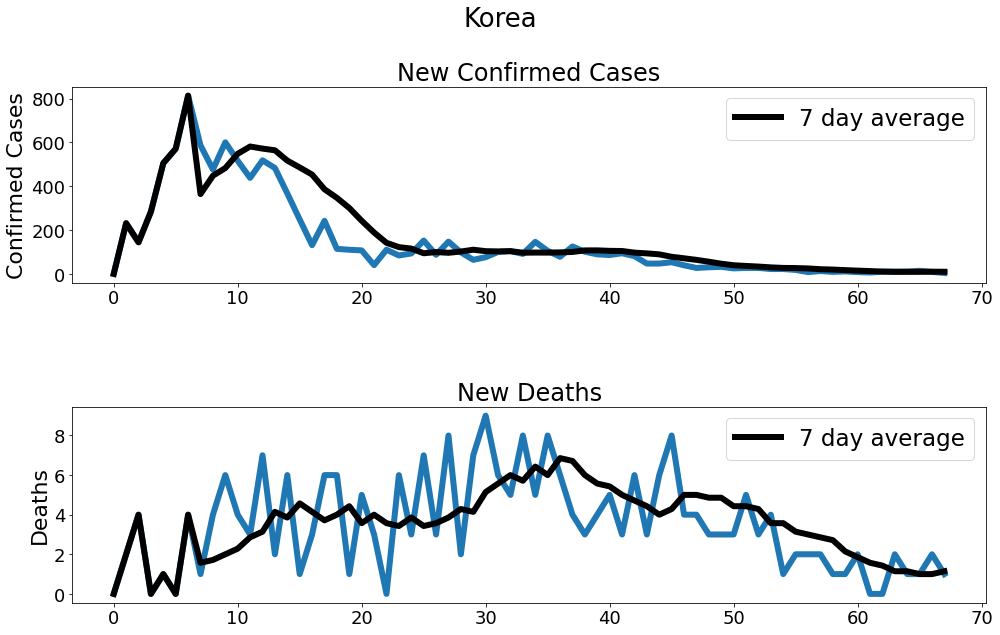

In [47]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (14,9))
fig.suptitle('Korea', fontsize = 26)
fig.subplots_adjust(top=.2)
# ax2.plot(deaths['ds'],deaths['dailyIncrease'])
# ax2.plot(deaths['ds'],averages2, 'k', label = '7 day average')
ax2.plot(deaths['dailyIncrease'])
ax2.plot(averages2, 'k', label = '7 day average')
ax2.set_ylabel('Deaths', fontsize = 22)
ax2.set_title('New Deaths', fontsize = 24)
ax2.tick_params(axis = 'both', labelsize = 18)
ax2.legend(fontsize = 23)

# ax1.plot(deaths['ds'], confirmed_data['dailyIncrease'])
# ax1.plot(deaths['ds'], averages, 'k', label = '7 day average')
ax1.plot(confirmed_data['dailyIncrease'])
ax1.plot(averages, 'k', label = '7 day average')
ax1.set_ylabel('Confirmed Cases', fontsize =22)
ax1.set_title('New Confirmed Cases', fontsize = 24)
ax1.tick_params(axis = 'both', labelsize = 18)
ax1.legend(fontsize = 23)
fig.tight_layout()

#plt.savefig('NewDeathsKorea.png', format='png', dpi=900, bbox_inches = 'tight')
#change x axis maybe?

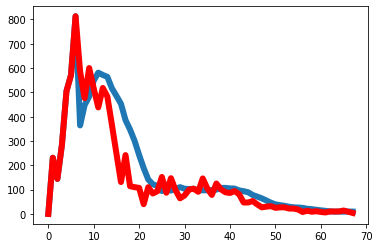

In [48]:
plt.plot(averages)
plt.plot(confirmed_data['dailyIncrease'], 'r')

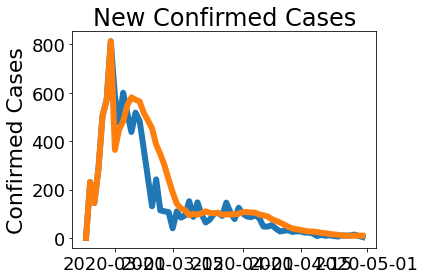

In [49]:
fig, ax1 = plt.subplots()

ax1.plot(deaths['ds'], confirmed_data['dailyIncrease'])
ax1.set_ylabel('Confirmed Cases', fontsize =22)
ax1.set_title('New Confirmed Cases', fontsize = 24)
ax1.tick_params(axis = 'both', labelsize = 18)
ax1.plot(deaths['ds'], averages)
fig.tight_layout()
plt.savefig('NewDeathsKorea.jpeg', quality = 95, bbox_inches = 'tight')

[364.0, 447.7142857142857, 482.7142857142857, 547.8571428571429, 581.0, 571.4285714285714, 563.8571428571429, 516.7142857142857, 485.42857142857144, 452.85714285714283, 385.85714285714283, 346.7142857142857, 300.42857142857144, 242.14285714285714, 188.42857142857142, 141.71428571428572, 122.0, 115.28571428571429, 94.0, 99.42857142857143, 96.14285714285714, 101.85714285714286, 110.14285714285714, 103.57142857142857, 102.42857142857143, 103.42857142857143, 96.57142857142857, 97.14285714285714, 97.0, 98.0, 100.0, 107.0, 107.14285714285714, 105.0, 104.28571428571429, 96.85714285714286, 93.42857142857143, 89.0, 77.85714285714286, 71.0, 63.857142857142854, 55.42857142857143, 46.285714285714285, 39.285714285714285, 36.142857142857146, 33.285714285714285, 29.571428571428573, 27.142857142857142, 26.428571428571427, 24.714285714285715, 21.285714285714285, 19.571428571428573, 17.0, 14.714285714285714, 12.714285714285714, 10.428571428571429, 9.285714285714286, 9.571428571428571, 9.142857142857142,

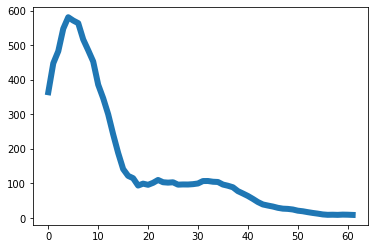

In [51]:
numbers = [1, 2, 3, 7, 9]
window_size = 7

numbers_series = pd.Series(confirmed_data['dailyIncrease'])
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

print(without_nans)
plt.plot(without_nans)

In [0]:
moving_averages_list = pd.DataFrame(moving_averages_list)
new_avg= moving_averages_list.shift(-4)

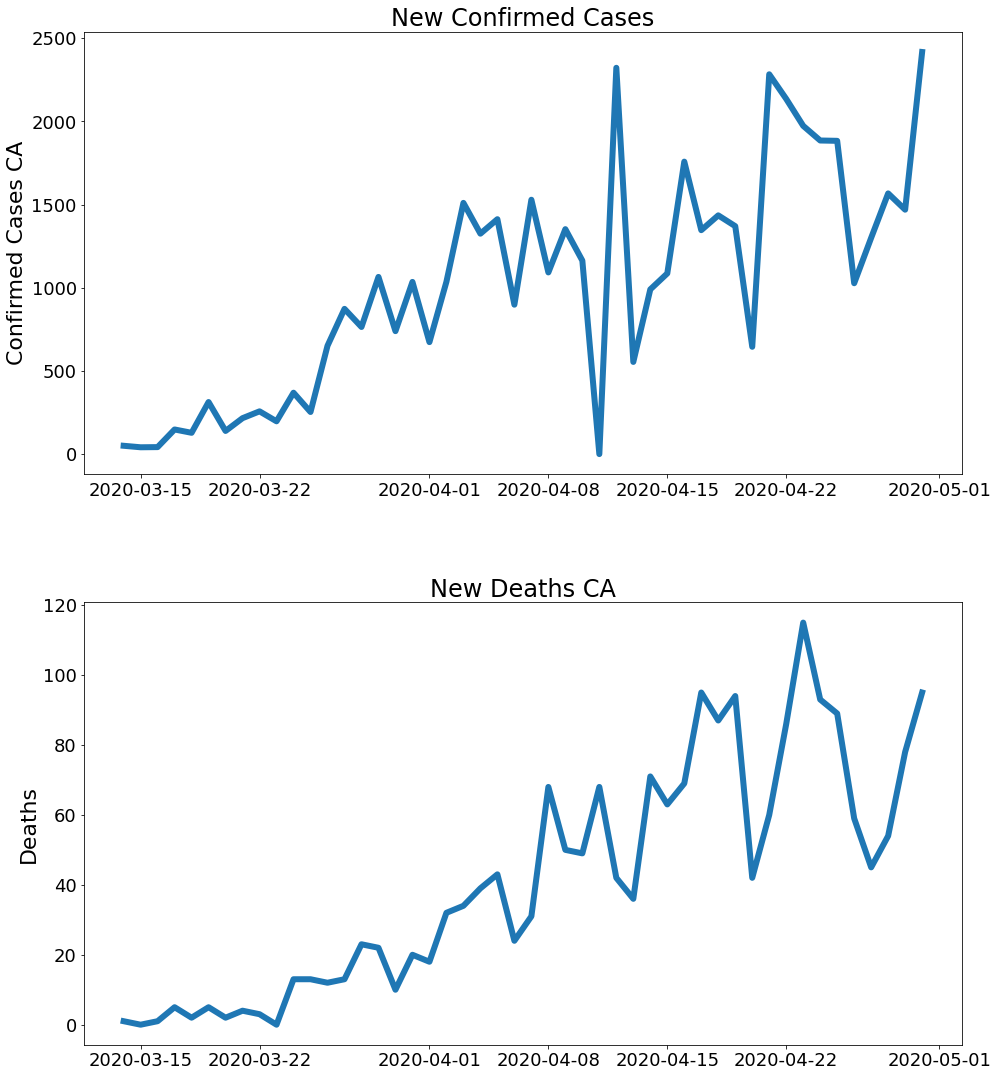

2417.0 115.0 CA confirmed, death, state


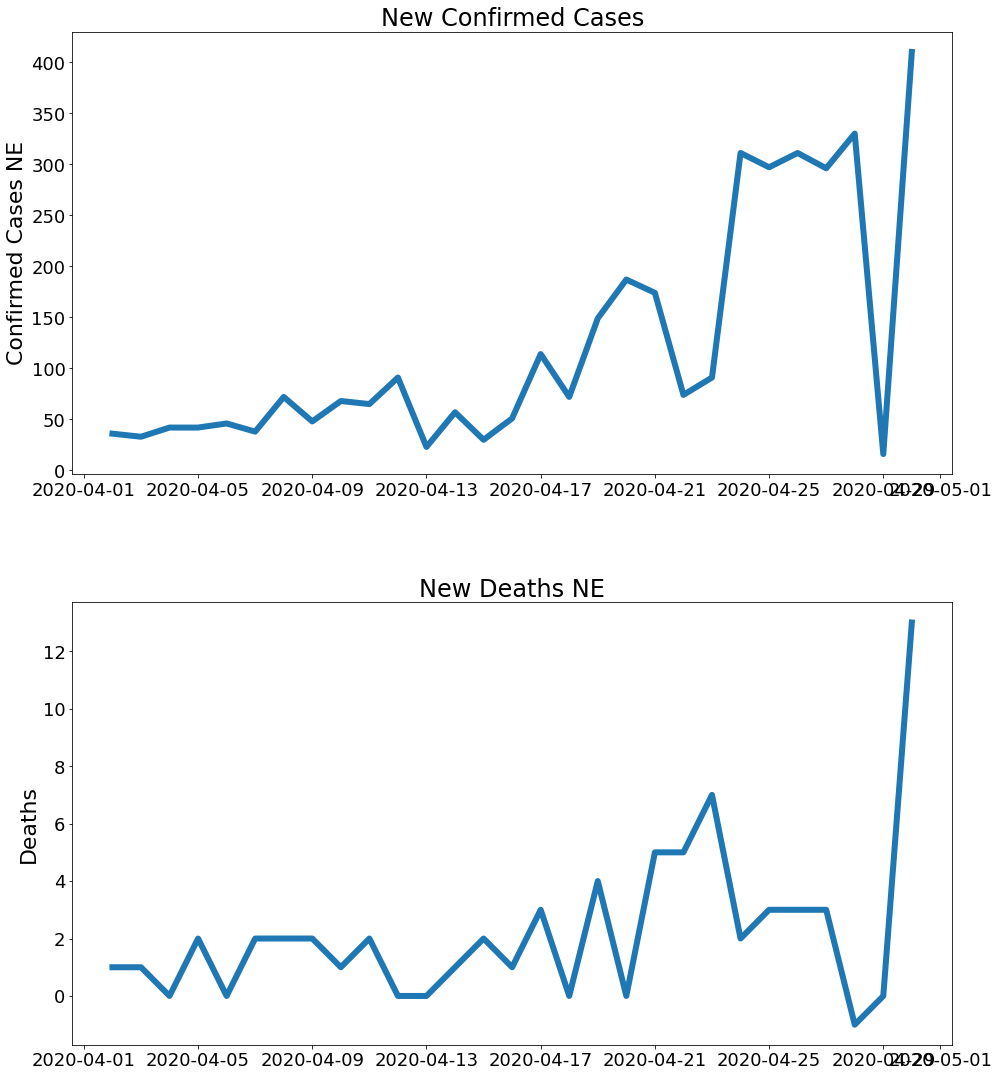

410.0 13.0 NE confirmed, death, state


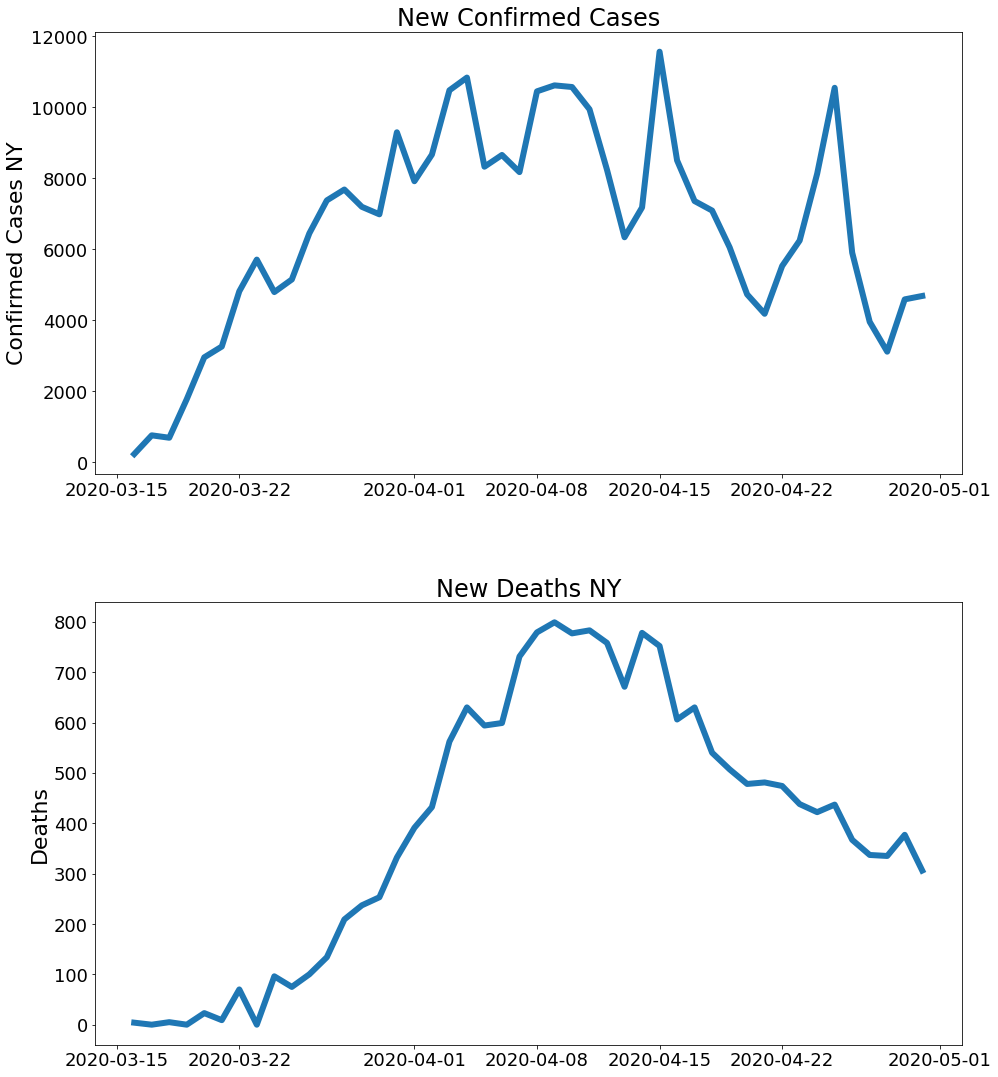

11571.0 799.0 NY confirmed, death, state


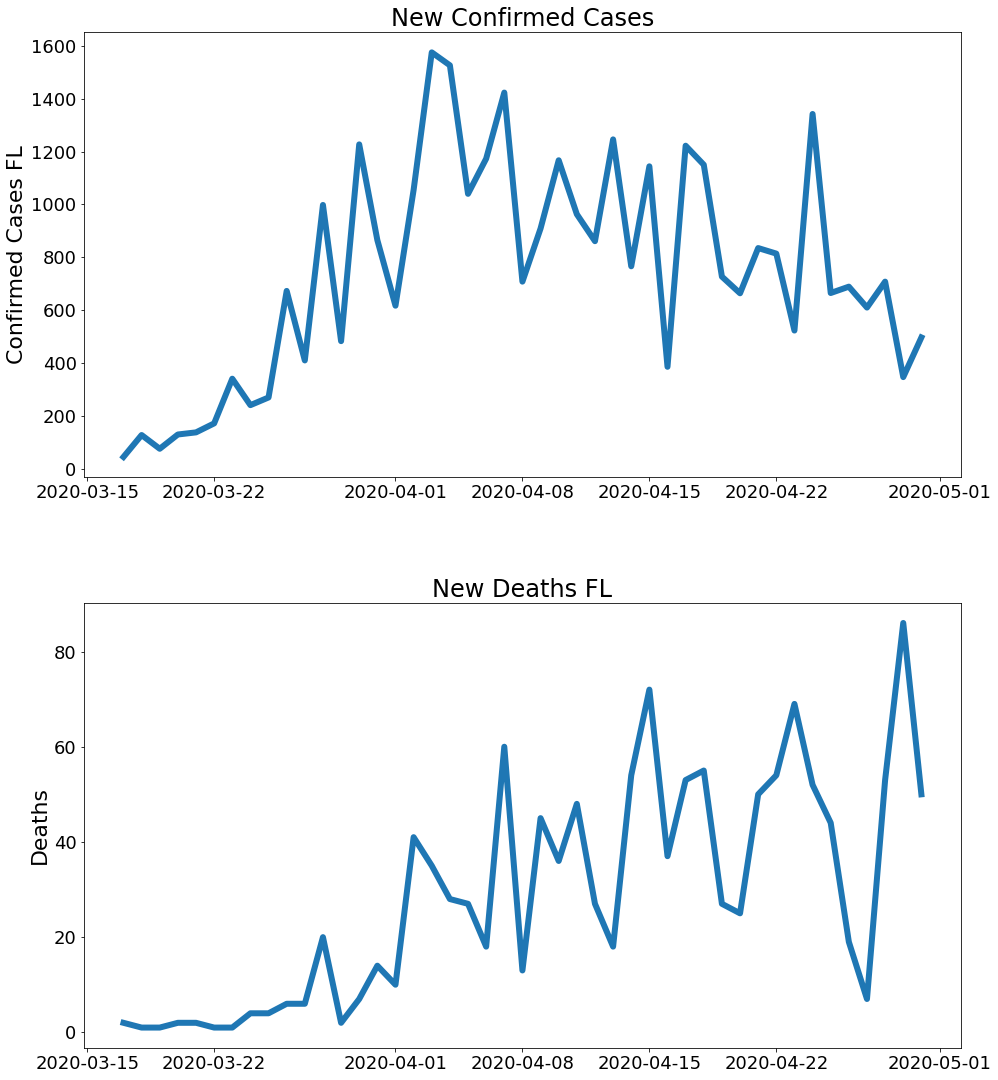

1575.0 86.0 FL confirmed, death, state


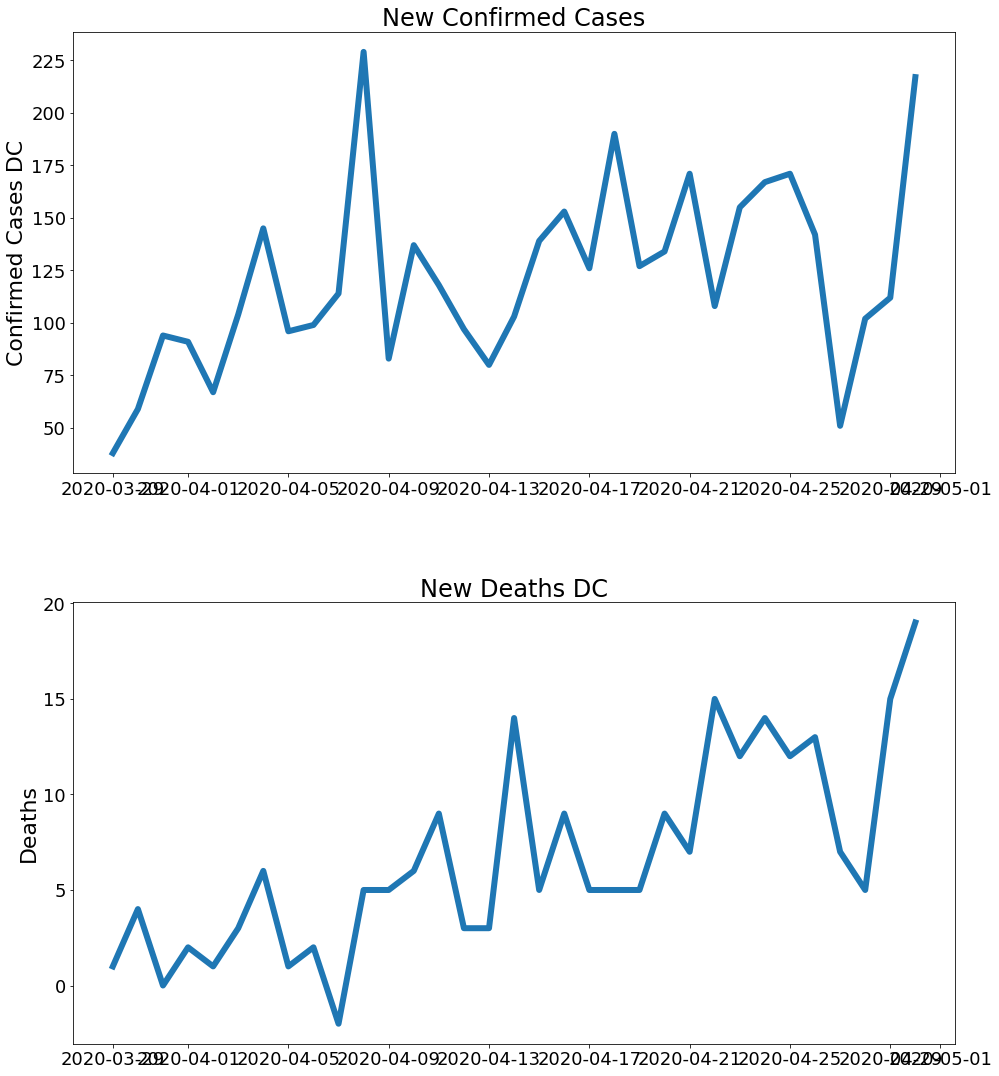

229.0 19.0 DC confirmed, death, state


In [53]:
for i in [CA,NE,NY,FL,DC]:
  fig, (ax1, ax2) = plt.subplots(2,1, figsize = (14,16))
  #fig.suptitle(i.state[0], fontsize = 26)
  fig.subplots_adjust(top=.2)
  ax2.plot(i['ds'],i['deathIncrease'])
  ax2.set_ylabel('Deaths', fontsize = 22)
  ax2.set_title('New Deaths %s' %i.state[0], fontsize = 24)
  ax2.tick_params(axis = 'both', labelsize = 18)

  ax1.plot(i['ds'], i['positiveIncrease'])
  ax1.set_ylabel('Confirmed Cases %s' %i.state[0], fontsize =22)
  ax1.set_title('New Confirmed Cases', fontsize = 24)
  ax1.tick_params(axis = 'both', labelsize = 18)
  fig.tight_layout()
  plt.show()
  print(np.max(i['positiveIncrease']), np.max(i['deathIncrease']), i['state'][0], 'confirmed, death, state')
#plt.savefig('NewDeathsKorea.jpeg', quality = 95, bbox_inches = 'tight')

Florida peak new cases 4-03
peak new deaths 4-29 (likely end of testing range)
passes 5 deaths 3-17

In [54]:
confirmed_data[confirmed_data['dailyIncrease'] == np.max(confirmed_data['dailyIncrease'])]

,index,ds,time,test,negative,y,released,deceased,confirmed_per_cap,negative_per_cap,test_per_cap,deceased_per_cap,dailyIncrease,cap
6,40,2020-02-29,16,94055,55723,3150,28,17,0.000061,0.001087,0.001835,3.315832e-07,813,13000


NY peak new cases 4-15
NY peak new deaths 4-09
NY passes 5 deaths 3-16

Korea peak new cases 2-29
Korea peak new deaths 3-24
Korea passes 5 deaths 2-23

Peak in confirmed cases 9 days after Church incident
Drop in confirmed cases 9 days after peak new casees


In [55]:
cvresult_simlogc = cross_validation(simlogc, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlogc.yhat, 
                                                           cvresult_simlogc.y)))
performance_metrics(cvresult_simlogc)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-26 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.0169.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,10915.292840,104.476279,90.422621,0.008773,0.008336,1.0
1,2 days,13631.797938,116.755291,97.594631,0.009380,0.010840,1.0
2,3 days,21044.013827,145.065550,126.671679,0.012179,0.013268,1.0
3,4 days,21617.230453,147.027992,121.847728,0.011595,0.011746,1.0
4,5 days,35073.759133,187.279895,172.272848,0.016426,0.015886,1.0
5,6 days,41441.525597,203.571918,191.570456,0.018233,0.019276,1.0
6,7 days,51882.321984,227.776913,210.903243,0.020021,0.020890,1.0
7,8 days,73266.465041,270.677788,243.539498,0.023026,0.023117,1.0
8,9 days,79357.789368,281.705146,246.912330,0.023233,0.024959,1.0
9,10 days,102667.425851,320.417580,275.885909,0.025922,0.026885,1.0


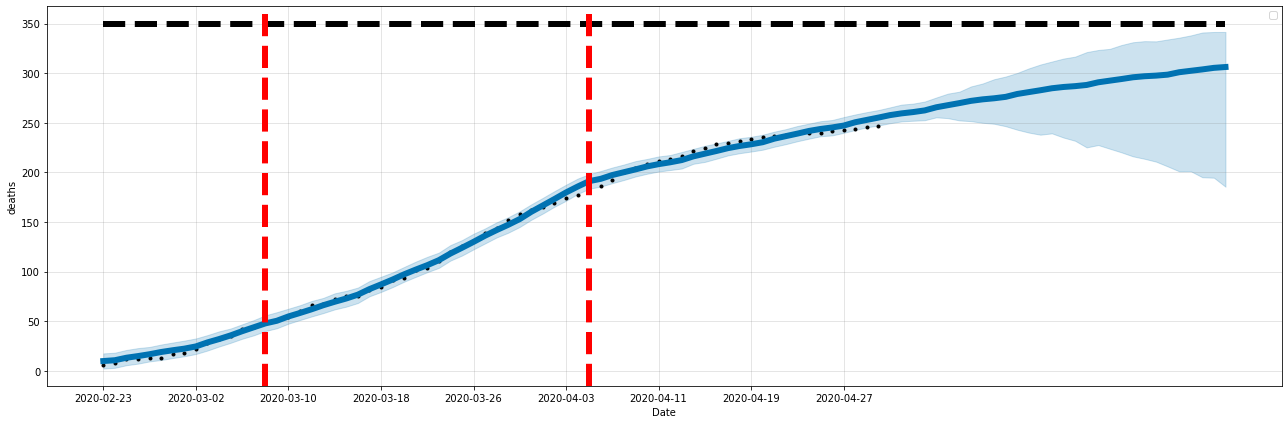

In [56]:
cap = 350
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=.25)

confirmed_train = deaths
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)

fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ticks = deaths['ds'][::8]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()
#2-27 Not used

In [57]:
cvresult_simlogd = cross_validation(simlogd, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlogd.yhat, 
                                                           cvresult_simlogd.y)))
performance_metrics(cvresult_simlogd)
#Result if you let it auto choose at .2: Mape is 1
#if you auto choose at 1: Mape is 5
#Putting in changepoints with 1 has MAPE of .4728
#Putting in changepoints with .2: Mape 1

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-03-26 00:00:00 and 2020-04-20 00:00:00


Mean absolute percentage error is  0.0442.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,26.237577,5.122263,4.257850,0.023292,0.026023,0.333333
1,2 days,40.878690,6.393644,5.455027,0.028129,0.028715,0.500000
2,3 days,46.979661,6.854171,6.274333,0.032147,0.039861,0.333333
3,4 days,75.684693,8.699695,7.855633,0.039517,0.045951,0.500000
4,5 days,84.526589,9.193834,8.000918,0.038029,0.038073,0.833333
5,6 days,114.283319,10.690338,9.062474,0.041988,0.050623,1.000000
6,7 days,149.596161,12.230951,11.046921,0.050893,0.058029,1.000000
7,8 days,187.746650,13.702067,12.309076,0.055170,0.061110,1.000000
8,9 days,237.891524,15.423732,14.385355,0.064446,0.072202,1.000000
9,10 days,287.453731,16.954460,15.631043,0.068791,0.080958,1.000000


In [0]:
NY.y.values.max()
NYY = NY.copy()
NYY['y'] = NY['positive']

,index,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,y,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,population,pos_per_cap,neg_per_cap,tot_per_cap,death_per_cap,cap
6,929,2020-03-22,NY,15168.0,46233.0,0.0,2043.0,1974.0,0.0,0.0,0.0,0.0,0.0,ad2d93083f335f0a9bfa72ed8711ba982bf1592c,2020-03-22T20:00:00Z,15168.0,1974.0,61401.0,61401.0,61401.0,36,70.0,371.0,11152.0,4812.0,15964.0,19440469,0.000780,0.002378,0.003158,0.000006,350000
12,1236,2020-03-28,NY,52318.0,103616.0,0.0,7328.0,10054.0,1755.0,0.0,0.0,0.0,2726.0,9d3efd380bf48a8a6a2ff98004ddd6a29a59c988,2020-03-28T20:00:00Z,52318.0,10054.0,155934.0,155934.0,155934.0,36,209.0,1528.0,2498.0,7683.0,10181.0,19440469,0.002691,0.005330,0.008021,0.000037,350000
18,1537,2020-04-03,NY,102863.0,157657.0,0.0,14810.0,23696.0,3731.0,0.0,0.0,0.0,8886.0,3581ea3846e784ce3996c873effe694f50617310,2020-04-03T20:00:00Z,102863.0,23696.0,260520.0,260520.0,260520.0,36,562.0,2879.0,11073.0,10482.0,21555.0,19440469,0.005291,0.008110,0.013401,0.000151,350000
23,1797,2020-04-08,NY,149316.0,215837.0,0.0,18079.0,34432.0,4593.0,0.0,0.0,0.0,16353.0,36db5397b3f156232e908feab224b44a19364028,2020-04-08T20:00:00Z,149316.0,34432.0,365153.0,365153.0,365153.0,36,779.0,2349.0,14642.0,10453.0,25095.0,19440469,0.007681,0.011102,0.018783,0.000322,350000
29,2104,2020-04-14,NY,202208.0,296935.0,0.0,18697.0,44286.0,5225.0,0.0,0.0,0.0,25589.0,466fb5c4b5d55c7c16dce6af3cffa46054a97b5d,2020-04-14T20:00:00Z,202208.0,44286.0,499143.0,499143.0,499143.0,36,778.0,1649.0,13609.0,7177.0,20786.0,19440469,0.010401,0.015274,0.025675,0.000557,350000
35,2404,2020-04-20,NY,247512.0,386349.0,0.0,16103.0,55188.0,5016.0,0.0,0.0,0.0,39085.0,4521a0110cede8ff0dda456d1e80ba441cc4c5f9,2020-04-20T20:00:00Z,247512.0,55188.0,633861.0,633861.0,633861.0,36,478.0,1379.0,11580.0,4726.0,16306.0,19440469,0.012732,0.019873,0.032605,0.000738,350000


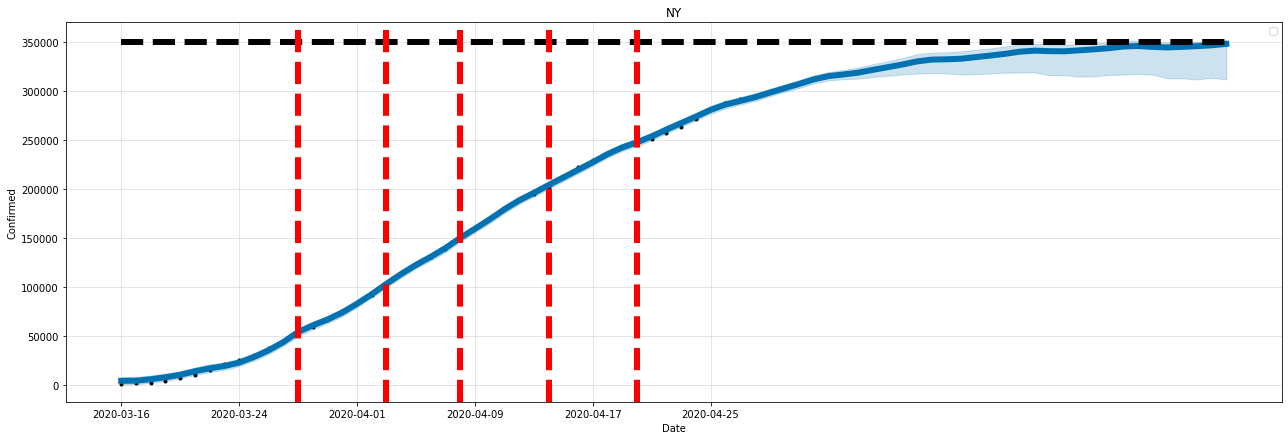

In [59]:
cap = 350000
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-03-24','2020-03-31','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=.25)

confirmed_train = NYY
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')
ticks = NY['ds'][::8]
ax.set_xticks(ticks)
ax.set_title(confirmed_train.state.values[0])
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()
NYY.loc[NYY["ds"].isin(simlogd.changepoints)]

,index,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,y,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,population,pos_per_cap,neg_per_cap,tot_per_cap,death_per_cap,cap
8,1033,2020-03-24,NY,25665.0,65605.0,0.0,3343.0,3234.0,0.0,0.0,0.0,0.0,0.0,d6f0b735999481a6fec3c24c58d95bc9ba13a6b3,2020-03-24T20:00:00Z,210.0,3234.0,91270.0,91270.0,91270.0,36,96.0,599.0,8191.0,4790.0,12981.0,19440469,0.001320,0.003375,0.004695,0.000011,22000
15,1388,2020-03-31,NY,75795.0,129391.0,0.0,10929.0,15904.0,2710.0,0.0,0.0,0.0,4975.0,b82085af96dba94baabf7e0b7cf6e7b539cce21b,2020-03-31T20:00:00Z,1550.0,15904.0,205186.0,205186.0,205186.0,36,332.0,2183.0,9420.0,9298.0,18718.0,19440469,0.003899,0.006656,0.010555,0.000080,22000
20,1644,2020-04-05,NY,122031.0,180249.0,0.0,16479.0,28092.0,4376.0,0.0,0.0,0.0,12187.0,58a99b83c7368e224acff5ea100e3692a0b8fa75,2020-04-05T20:00:00Z,4159.0,28092.0,302280.0,302280.0,302280.0,36,594.0,1709.0,10332.0,8327.0,18659.0,19440469,0.006277,0.009272,0.015549,0.000214,22000


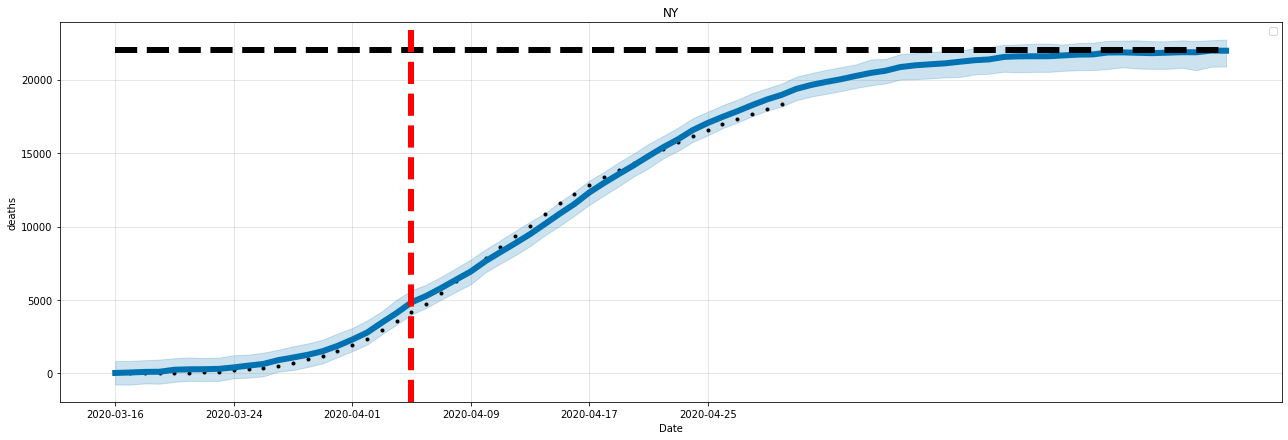

In [60]:
#New York
cap = 22000
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-03-24','2020-03-31','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=.25)

confirmed_train = NY
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ticks = NY['ds'][::8]
ax.set_xticks(ticks)
ax.set_title(confirmed_train.state.values[0])
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()
NY.loc[NY["ds"].isin(simlogd.changepoints)]

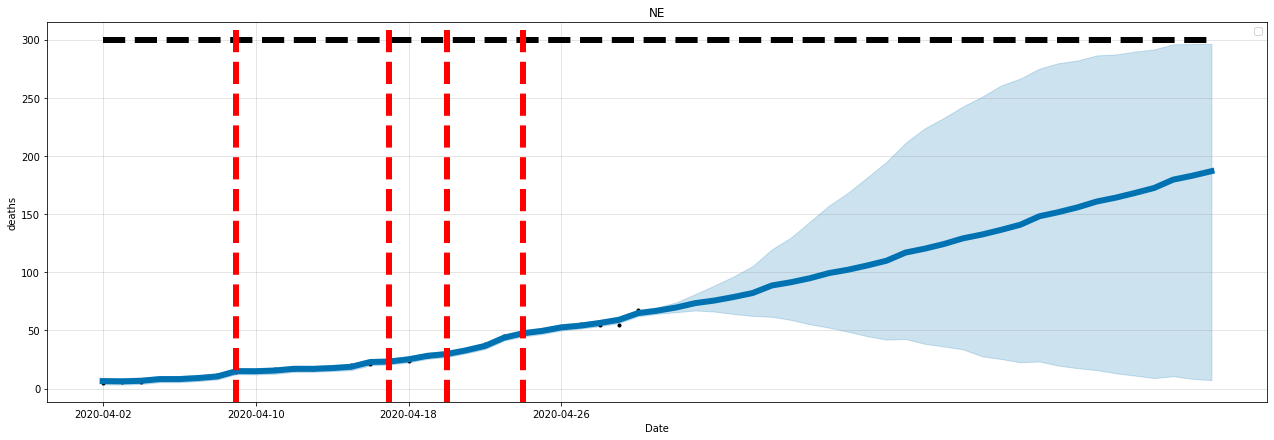

In [61]:
#Nebraska
cap = 300
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = NE
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ticks = NE['ds'][::8]
ax.set_xticks(ticks)
ax.set_title(confirmed_train.state.values[0])
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()

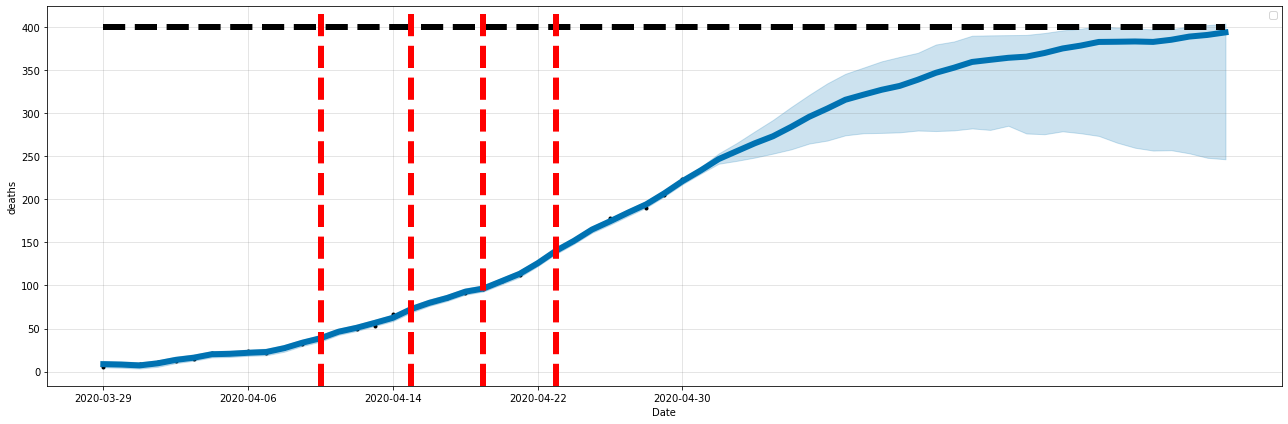

In [62]:
#DC
cap = 400
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = DC
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ticks = DC['ds'][::8]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()

,index,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,y,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,population,pos_per_cap,neg_per_cap,tot_per_cap,death_per_cap,cap
6,947,2020-03-23,FL,1171.0,11063.0,860.0,0.0,217.0,0.0,0.0,0.0,0.0,0.0,fefea265e78e4106c70c1907bee630dd8b5d76ad,2020-03-23T20:00:00Z,14.0,217.0,13094.0,12234.0,12234.0,12,1.0,32.0,3073.0,341.0,3414.0,21992985,0.000053,0.000503,0.000595,6.365666e-07,2000
12,1253,2020-03-29,FL,4246.0,39070.0,0.0,0.0,594.0,0.0,0.0,0.0,0.0,0.0,39553e3ec095e3143e776031465d2e90ade6c787,2020-03-29T20:00:00Z,56.0,594.0,43316.0,43316.0,43316.0,12,2.0,68.0,3704.0,483.0,4187.0,21992985,0.000193,0.001776,0.001970,2.546266e-06,2000
18,1560,2020-04-04,FL,11111.0,90956.0,1281.0,0.0,1462.0,0.0,0.0,0.0,0.0,0.0,1f993ebcc7b85b2f8281d911efc5e3c78dda42e8,2020-04-04T20:00:00Z,191.0,1462.0,103348.0,102067.0,102067.0,12,28.0,175.0,8819.0,1526.0,10345.0,21992985,0.000505,0.004136,0.004699,8.684587e-06,2000
23,1814,2020-04-09,FL,16364.0,136185.0,1395.0,0.0,2268.0,0.0,0.0,0.0,0.0,0.0,754e4c4bc873607e36e18febcf6f6f3fe17eef34,2020-04-09T20:00:00Z,354.0,2268.0,153944.0,152549.0,152549.0,12,45.0,206.0,8506.0,909.0,9415.0,21992985,0.000744,0.006192,0.007000,1.609604e-05,2000
29,2120,2020-04-15,FL,22511.0,190998.0,1335.0,0.0,3344.0,0.0,0.0,0.0,0.0,0.0,f8fa87d0742465433075ca7eaf8ea8118844a595,2020-04-15T20:00:00Z,609.0,3344.0,214844.0,213509.0,213509.0,12,72.0,284.0,9185.0,1144.0,10329.0,21992985,0.001024,0.008684,0.009769,2.769065e-05,2000
35,2427,2020-04-21,FL,27495.0,249564.0,1203.0,0.0,4235.0,0.0,0.0,0.0,0.0,0.0,9f821074949d5d6047e4448cf38da1ff4ef699a6,2020-04-21T20:00:00Z,856.0,4235.0,278262.0,277059.0,277059.0,12,50.0,225.0,9999.0,835.0,10834.0,21992985,0.001250,0.011347,0.012652,3.892150e-05,2000


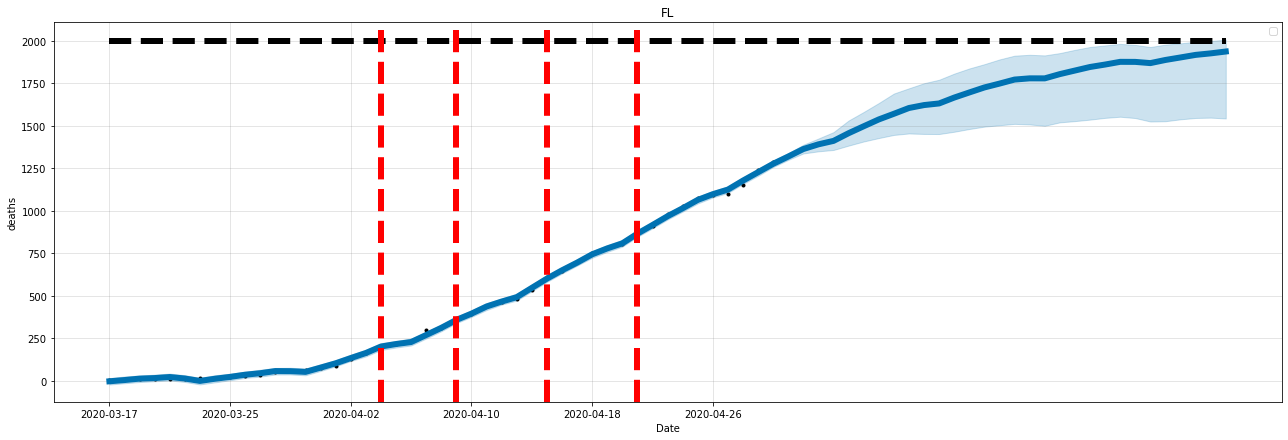

In [63]:
#FLORIDA
cap = 2000
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = FL
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ax.set_title(confirmed_train.state.values[0])
ticks = FL['ds'][::8]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()
FL.loc[FL["ds"].isin(simlogd.changepoints)]

,index,ds,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,y,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,population,pos_per_cap,neg_per_cap,tot_per_cap,death_per_cap,cap
6,798,2020-03-20,CA,1063.0,10424.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22cfcbb820f66309386b4bdfdf47a806dd894a62,2020-03-20T20:00:00Z,20.0,0.0,11487.0,11487.0,11487.0,6,2.0,0.0,1637.0,139.0,1776.0,39937489,0.000027,0.000261,0.000288,5.007826e-07,3500
12,1106,2020-03-26,CA,3006.0,17380.0,57400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d073989819811eaa4edd1a4f71a3716c44b653ac,2020-03-26T20:00:00Z,65.0,0.0,77786.0,20386.0,20386.0,6,12.0,0.0,1459.0,651.0,2110.0,39937489,0.000075,0.000435,0.001948,1.627543e-06,3500
18,1410,2020-04-01,CA,8155.0,21772.0,57400.0,1855.0,0.0,774.0,0.0,0.0,0.0,0.0,36cc579cf1bdcc8118bbf943a1f3239abe7ce41b,2020-04-01T20:00:00Z,171.0,0.0,87327.0,29927.0,29927.0,6,18.0,0.0,0.0,673.0,673.0,39937489,0.000204,0.000545,0.002187,4.281691e-06,3500
25,1767,2020-04-08,CA,16957.0,127307.0,14600.0,2714.0,0.0,1154.0,0.0,0.0,0.0,0.0,c597c8b5b77b179c9e590a881c97d79fea2bd2db,2020-04-08T20:00:00Z,442.0,0.0,158864.0,144264.0,144264.0,6,68.0,0.0,11943.0,1092.0,13035.0,39937489,0.000425,0.003188,0.003978,1.106730e-05,3500
31,2072,2020-04-14,CA,23338.0,178870.0,13200.0,5163.0,0.0,1552.0,0.0,0.0,0.0,0.0,1f65c8b2d5328790f9cbedda2bfe2325921ed07a,2020-04-14T20:00:00Z,758.0,0.0,215408.0,202208.0,202208.0,6,71.0,0.0,10336.0,990.0,11326.0,39937489,0.000584,0.004479,0.005394,1.897966e-05,3500
37,2379,2020-04-20,CA,30978.0,259522.0,0.0,4674.0,0.0,1480.0,0.0,0.0,0.0,0.0,41576d2aea97b9aeda709ef2fc0ca31cedad7b7a,2020-04-20T20:00:00Z,1208.0,0.0,290500.0,290500.0,290500.0,6,42.0,0.0,8955.0,645.0,9600.0,39937489,0.000776,0.006498,0.007274,3.024727e-05,3500


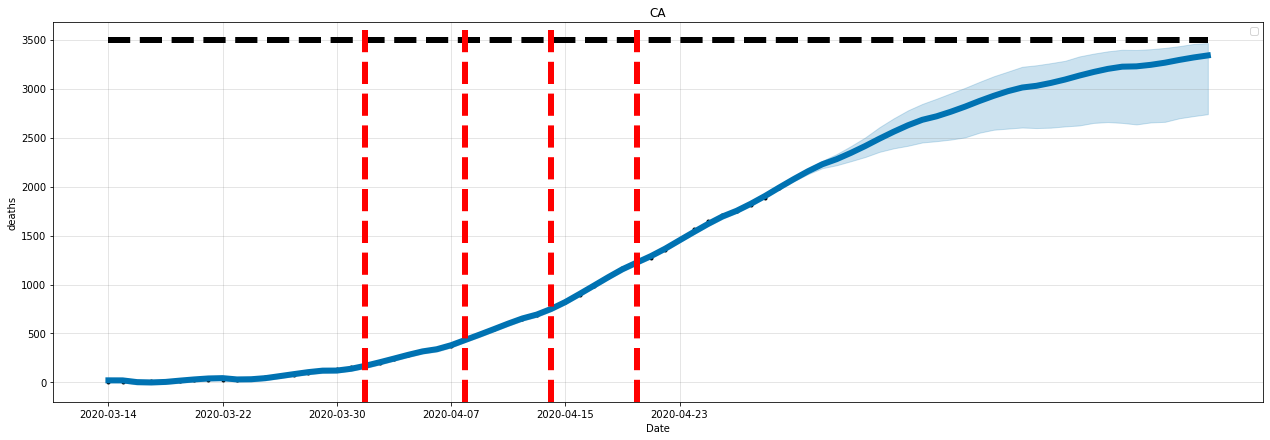

In [64]:
#California
cap = 3500
simlogd = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-27','2020-03-08','2020-04-05'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)

confirmed_train = CA
confirmed_train['cap'] = cap
simlogd.fit(confirmed_train)
future = simlogd.make_future_dataframe(periods=30)
future['cap'] = cap
forecast = simlogd.predict(future)



fig5, ax = plt.subplots(figsize=(18,6))
simlogd.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('deaths')
ax.set_title(confirmed_train.state.values[0])
ticks = CA['ds'][::8]
ax.set_xticks(ticks)
#
#ax.plot(confirmed_data[-20:].ds,confirmed_data[-20:].y,'.',c='r',label='Actual curve')

a5 = add_changepoints_to_plot(fig5.gca(), simlogd, forecast,trend=False)
ax.legend()
CA.loc[CA["ds"].isin(simlogd.changepoints)]

In [65]:
a5[0]

In [66]:
type(a5)

list

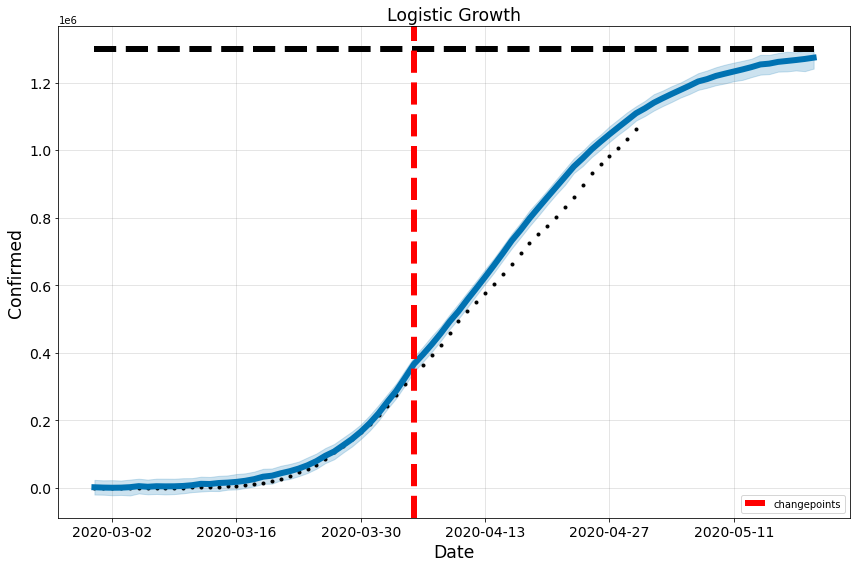

In [67]:
figvs, (ax2) = plt.subplots(1,1,figsize=(12,8))
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 1300000
forecast = simlog2.predict(future)
figvs2=simlog2.plot(forecast,ax=ax2)
ax2.set_xlabel('Date',fontsize='xx-large')
ax2.set_ylabel('Confirmed',fontsize='xx-large')
ax2.set_title('Logistic Growth',fontsize='xx-large')
a2 = add_changepoints_to_plot(ax=ax2, m=simlog2, fcst=forecast,trend = False)

ax2.tick_params(axis='both', which='major', labelsize=14)

#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
a2[0].set_label('changepoints')
ax2.legend(loc=4)

figvs.tight_layout()
plt.show()

In [68]:
korea.deceased_per_cap

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
97     0.000005
98     0.000005
99     0.000005
100    0.000005
101    0.000005
Name: deceased_per_cap, Length: 102, dtype: float64

In [69]:
deaths.values[34]

array([68, Timestamp('2020-03-28 00:00:00'), 0, 387925, 361883, 9478,
       4811, 144, 0.00018486738183959818, 0.007058489422057323,
       0.00756643586200951, 2.808704682939665e-06, 5, 350], dtype=object)

Repeat this for the curve fit

In [70]:
ind = deaths['dailyIncrease'].idxmax(axis = 1)
ind = ind - 34
print(ind)
deaths.ds[ind+34]

-4


Timestamp('2020-03-24 00:00:00')

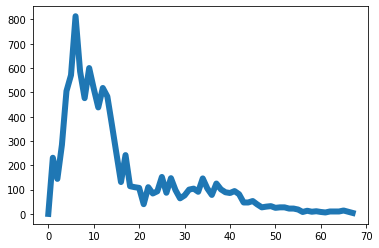

In [71]:
plt.plot(confirmed_data['dailyIncrease'])

In [72]:
ind = confirmed_data['dailyIncrease'].idxmax(axis = 1)
ind = ind - 34
print(ind)
deaths.ds[ind+34]

-28


Timestamp('2020-02-29 00:00:00')

Repeat this for U.S. + States